In [1]:
import os
os.chdir("../..")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils.dataset_loader import *
from utils.model_utils import *
from utils.train_utils import *
from utils.metrics import *
from utils.visualization import *
import optuna
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [4]:
os.makedirs("outputs/models", exist_ok=True)
os.makedirs("outputs/plots", exist_ok=True)

In [5]:
print("[INFO] Loading datasets...")
train_loader, val_loader, test_loader = load_datasets(
    "wildfire_dataset_scaled", batch_size=16, augmentation="augmented"
)
print("[INFO] Datasets loaded successfully!")

2024-12-24 23:33:41,199 - INFO - Loading datasets from wildfire_dataset_scaled with augmentation type 'augmented'.
2024-12-24 23:33:41,200 - INFO - Applying selected augmentations for wildfire scenarios.
2024-12-24 23:33:41,209 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/train
2024-12-24 23:33:41,211 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/val
2024-12-24 23:33:41,213 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/test
2024-12-24 23:33:41,215 - INFO - Datasets initialized. Preparing DataLoaders...
2024-12-24 23:33:41,215 - INFO - Using WeightedRandomSampler for class balancing.
2024-12-24 23:33:41,215 - INFO - Computing class weights from directory: wildfire_dataset_scaled/train
2024-12-24 23:33:41,216 - INFO - Class 'fire' has 730 samples.
2024-12-24 23:33:41,218 - INFO - Class 'nofire' has 1157 samples.
2024-12-24 23:33:41,218 - INFO - Computed class weights: {'fire': 1.0, 'nofire': 

[INFO] Loading datasets...


2024-12-24 23:33:48,285 - INFO - DataLoaders created successfully.


[INFO] Datasets loaded successfully!


In [6]:
def objective(trial):
    print(f"[DEBUG] Starting trial {trial.number}...")

    # Hyperparameter suggestions
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])
    print(f"[DEBUG] Suggested hyperparameters: lr={lr}, weight_decay={weight_decay}, optimizer={optimizer_name}")

    # Initialize model
    print("[DEBUG] Initializing resnet18 model...")
    model = initialize_model("resnet18", num_classes=2, pretrained=True, freeze_all=False, unfreeze_last_n=8)
    model.to(device)

    # Optimizer setup
    print("[DEBUG] Setting up optimizer...")
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.5)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Train the model
    print("[INFO] Starting model training...")
    save_path = "outputs/models/tuned/resnet18_trial_best.pth"
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        save_path=save_path,
        early_stop_patience=5,
        monitor_metric="val_f1",
    )
    print("[INFO] Training completed!")

    # Return validation recall
    val_recall = history["val_f1"][-1]
    print(f"[INFO] Trial {trial.number} - Final Validation F1: {val_recall:.4f}")
    return val_recall


In [7]:
# Run Optuna

import time

# Start the timer
start_time = time.time()
print("Trials started...")


print("[INFO] Running hyperparameter optimization...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print(f"[INFO] Best parameters found: {study.best_params}")

# Calculate and display elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Format elapsed time as hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Trials completed in {hours} hours, {minutes} minutes, and {seconds} seconds.")


[I 2024-12-24 23:33:48,297] A new study created in memory with name: no-name-c03c758a-456b-4df2-b574-fcf568685f3d


Trials started...
[INFO] Running hyperparameter optimization...
[DEBUG] Starting trial 0...
[DEBUG] Suggested hyperparameters: lr=0.004687068748945872, weight_decay=0.0008733813744530674, optimizer=SGD
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.004687
[INFO] Best model saved with val_f1: 0.7818
Epoch [1]: Train Loss: 1.0883, Train Acc: 0.6619 | Val Loss: 1.0797, Val Acc: 0.6667, Val Recall: 0.9756, Val F1: 0.7818


[INFO] Learning rate adjusted to: 0.004687
[INFO] Best model saved with val_f1: 0.7877
Epoch [2]: Train Loss: 0.9518, Train Acc: 0.6937 | Val Loss: 1.0234, Val Acc: 0.6741, Val Recall: 0.9878, Val F1: 0.7877


[INFO] Learning rate adjusted to: 0.004687
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [3]: Train Loss: 0.7001, Train Acc: 0.7583 | Val Loss: 0.6532, Val Acc: 0.7488, Val Recall: 0.6179, Val F1: 0.7506


[INFO] Learning rate adjusted to: 0.004687
[INFO] Best model saved with val_f1: 0.8648
Epoch [4]: Train Loss: 0.5363, Train Acc: 0.8002 | Val Loss: 0.5605, Val Acc: 0.8234, Val Recall: 0.9228, Val F1: 0.8648


[INFO] Learning rate adjusted to: 0.004687
[INFO] Best model saved with val_f1: 0.8922
Epoch [5]: Train Loss: 0.3707, Train Acc: 0.8500 | Val Loss: 0.3768, Val Acc: 0.8582, Val Recall: 0.9593, Val F1: 0.8922


[INFO] Learning rate adjusted to: 0.004687
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.4061, Train Acc: 0.8495 | Val Loss: 0.4797, Val Acc: 0.8234, Val Recall: 0.9309, Val F1: 0.8658


[INFO] Learning rate adjusted to: 0.004687
[INFO] Best model saved with val_f1: 0.9039
Epoch [7]: Train Loss: 0.3066, Train Acc: 0.8829 | Val Loss: 0.3081, Val Acc: 0.8831, Val Recall: 0.8984, Val F1: 0.9039


[INFO] Learning rate adjusted to: 0.004687
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.2296, Train Acc: 0.9073 | Val Loss: 0.4499, Val Acc: 0.8507, Val Recall: 0.8577, Val F1: 0.8755


[INFO] Learning rate adjusted to: 0.004687
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [9]: Train Loss: 0.2920, Train Acc: 0.8898 | Val Loss: 0.3977, Val Acc: 0.8308, Val Recall: 0.8415, Val F1: 0.8589


[INFO] Learning rate adjusted to: 0.004687
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [10]: Train Loss: 0.2440, Train Acc: 0.9115 | Val Loss: 0.3644, Val Acc: 0.8607, Val Recall: 0.8780, Val F1: 0.8852


[INFO] Learning rate adjusted to: 0.002344
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [11]: Train Loss: 0.3180, Train Acc: 0.9004 | Val Loss: 0.6372, Val Acc: 0.8035, Val Recall: 0.7764, Val F1: 0.8286


[INFO] Learning rate adjusted to: 0.002344
[INFO] Best model saved with val_f1: 0.9091
Epoch [12]: Train Loss: 0.2345, Train Acc: 0.9184 | Val Loss: 0.3145, Val Acc: 0.8856, Val Recall: 0.9350, Val F1: 0.9091


[INFO] Learning rate adjusted to: 0.002344
[INFO] Best model saved with val_f1: 0.9234
Epoch [13]: Train Loss: 0.1446, Train Acc: 0.9459 | Val Loss: 0.3287, Val Acc: 0.9055, Val Recall: 0.9309, Val F1: 0.9234


[INFO] Learning rate adjusted to: 0.002344
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.1557, Train Acc: 0.9491 | Val Loss: 0.3270, Val Acc: 0.8955, Val Recall: 0.9390, Val F1: 0.9167


[INFO] Learning rate adjusted to: 0.002344
[INFO] Best model saved with val_f1: 0.9240
Epoch [15]: Train Loss: 0.1251, Train Acc: 0.9528 | Val Loss: 0.2884, Val Acc: 0.9080, Val Recall: 0.9146, Val F1: 0.9240


[INFO] Learning rate adjusted to: 0.002344
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [16]: Train Loss: 0.0943, Train Acc: 0.9661 | Val Loss: 0.3654, Val Acc: 0.8930, Val Recall: 0.9228, Val F1: 0.9135


[INFO] Learning rate adjusted to: 0.002344
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [17]: Train Loss: 0.1032, Train Acc: 0.9640 | Val Loss: 0.2941, Val Acc: 0.9055, Val Recall: 0.9228, Val F1: 0.9228


[INFO] Learning rate adjusted to: 0.002344
[INFO] Best model saved with val_f1: 0.9331
Epoch [18]: Train Loss: 0.0803, Train Acc: 0.9661 | Val Loss: 0.3065, Val Acc: 0.9179, Val Recall: 0.9350, Val F1: 0.9331


[INFO] Learning rate adjusted to: 0.002344
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [19]: Train Loss: 0.0987, Train Acc: 0.9666 | Val Loss: 0.3357, Val Acc: 0.8980, Val Recall: 0.9390, Val F1: 0.9185


[INFO] Learning rate adjusted to: 0.002344
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [20]: Train Loss: 0.0839, Train Acc: 0.9719 | Val Loss: 0.3324, Val Acc: 0.9055, Val Recall: 0.9268, Val F1: 0.9231


[INFO] Learning rate adjusted to: 0.002344
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [21]: Train Loss: 0.0767, Train Acc: 0.9756 | Val Loss: 0.3826, Val Acc: 0.9080, Val Recall: 0.9146, Val F1: 0.9240


[INFO] Learning rate adjusted to: 0.001172
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [22]: Train Loss: 0.0808, Train Acc: 0.9730 | Val Loss: 0.3862, Val Acc: 0.8980, Val Recall: 0.9472, Val F1: 0.9191


[I 2024-12-24 23:39:11,366] Trial 0 finished with value: 0.9267326732673268 and parameters: {'lr': 0.004687068748945872, 'weight_decay': 0.0008733813744530674, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.9267326732673268.


[INFO] Learning rate adjusted to: 0.001172
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [23]: Train Loss: 0.0676, Train Acc: 0.9815 | Val Loss: 0.2795, Val Acc: 0.9080, Val Recall: 0.9512, Val F1: 0.9267
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 23 epochs. Best val_f1: 0.9331

[INFO] Training completed!
[INFO] Trial 0 - Final Validation F1: 0.9267
[DEBUG] Starting trial 1...
[DEBUG] Suggested hyperparameters: lr=2.6086281087862917e-05, weight_decay=0.0008053681146232245, optimizer=Adam
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000026
[INFO] Best model saved with val_f1: 0.8880
Epoch [1]: Train Loss: 0.4063, Train Acc: 0.8119 | Val Loss: 0.3148, Val Acc: 0.8632, Val Recall: 0.8862, Val F1: 0.8880


[INFO] Learning rate adjusted to: 0.000026
[INFO] Best model saved with val_f1: 0.9150
Epoch [2]: Train Loss: 0.2521, Train Acc: 0.8930 | Val Loss: 0.2911, Val Acc: 0.8955, Val Recall: 0.9187, Val F1: 0.9150


[INFO] Learning rate adjusted to: 0.000026
[INFO] Best model saved with val_f1: 0.9256
Epoch [3]: Train Loss: 0.1976, Train Acc: 0.9200 | Val Loss: 0.2558, Val Acc: 0.9080, Val Recall: 0.9350, Val F1: 0.9256


[INFO] Learning rate adjusted to: 0.000026
[INFO] Best model saved with val_f1: 0.9273
Epoch [4]: Train Loss: 0.1618, Train Acc: 0.9375 | Val Loss: 0.2227, Val Acc: 0.9080, Val Recall: 0.9593, Val F1: 0.9273


[INFO] Learning rate adjusted to: 0.000026
[INFO] Best model saved with val_f1: 0.9344
Epoch [5]: Train Loss: 0.1292, Train Acc: 0.9491 | Val Loss: 0.2341, Val Acc: 0.9179, Val Recall: 0.9553, Val F1: 0.9344


[INFO] Learning rate adjusted to: 0.000026
[INFO] Best model saved with val_f1: 0.9357
Epoch [6]: Train Loss: 0.0810, Train Acc: 0.9719 | Val Loss: 0.2131, Val Acc: 0.9204, Val Recall: 0.9472, Val F1: 0.9357


[INFO] Learning rate adjusted to: 0.000026
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.0938, Train Acc: 0.9666 | Val Loss: 0.2256, Val Acc: 0.9179, Val Recall: 0.9472, Val F1: 0.9339


[INFO] Learning rate adjusted to: 0.000026
[INFO] Best model saved with val_f1: 0.9363
Epoch [8]: Train Loss: 0.0663, Train Acc: 0.9783 | Val Loss: 0.2309, Val Acc: 0.9204, Val Recall: 0.9553, Val F1: 0.9363


[INFO] Learning rate adjusted to: 0.000026
[INFO] Best model saved with val_f1: 0.9407
Epoch [9]: Train Loss: 0.0770, Train Acc: 0.9724 | Val Loss: 0.2290, Val Acc: 0.9254, Val Recall: 0.9675, Val F1: 0.9407


[INFO] Learning rate adjusted to: 0.000026
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [10]: Train Loss: 0.0678, Train Acc: 0.9756 | Val Loss: 0.2096, Val Acc: 0.9154, Val Recall: 0.9309, Val F1: 0.9309


[INFO] Learning rate adjusted to: 0.000026
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [11]: Train Loss: 0.0597, Train Acc: 0.9767 | Val Loss: 0.2274, Val Acc: 0.9129, Val Recall: 0.9553, Val F1: 0.9307


[INFO] Learning rate adjusted to: 0.000026
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [12]: Train Loss: 0.0496, Train Acc: 0.9804 | Val Loss: 0.2287, Val Acc: 0.9179, Val Recall: 0.9593, Val F1: 0.9347


[INFO] Learning rate adjusted to: 0.000013
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [13]: Train Loss: 0.0326, Train Acc: 0.9899 | Val Loss: 0.2678, Val Acc: 0.9080, Val Recall: 0.9634, Val F1: 0.9276


[I 2024-12-24 23:42:25,819] Trial 1 finished with value: 0.9322709163346613 and parameters: {'lr': 2.6086281087862917e-05, 'weight_decay': 0.0008053681146232245, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.9322709163346613.


[INFO] Learning rate adjusted to: 0.000013
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [14]: Train Loss: 0.0332, Train Acc: 0.9878 | Val Loss: 0.2596, Val Acc: 0.9154, Val Recall: 0.9512, Val F1: 0.9323
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 14 epochs. Best val_f1: 0.9407

[INFO] Training completed!
[INFO] Trial 1 - Final Validation F1: 0.9323
[DEBUG] Starting trial 2...
[DEBUG] Suggested hyperparameters: lr=0.00138412966878561, weight_decay=0.0009661042155079605, optimizer=SGD
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.001384
[INFO] Best model saved with val_f1: 0.8375
Epoch [1]: Train Loss: 0.4567, Train Acc: 0.7912 | Val Loss: 0.4984, Val Acc: 0.8234, Val Recall: 0.7439, Val F1: 0.8375


[INFO] Learning rate adjusted to: 0.001384
[INFO] Best model saved with val_f1: 0.9216
Epoch [2]: Train Loss: 0.3363, Train Acc: 0.8792 | Val Loss: 0.2649, Val Acc: 0.9005, Val Recall: 0.9553, Val F1: 0.9216


[INFO] Learning rate adjusted to: 0.001384
[INFO] Best model saved with val_f1: 0.9325
Epoch [3]: Train Loss: 0.2525, Train Acc: 0.9115 | Val Loss: 0.2707, Val Acc: 0.9179, Val Recall: 0.9268, Val F1: 0.9325


[INFO] Learning rate adjusted to: 0.001384
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.2207, Train Acc: 0.9136 | Val Loss: 0.2652, Val Acc: 0.9129, Val Recall: 0.9756, Val F1: 0.9320


[INFO] Learning rate adjusted to: 0.001384
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [5]: Train Loss: 0.1369, Train Acc: 0.9497 | Val Loss: 0.3118, Val Acc: 0.8881, Val Recall: 0.9634, Val F1: 0.9133


[INFO] Learning rate adjusted to: 0.001384
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [6]: Train Loss: 0.1720, Train Acc: 0.9385 | Val Loss: 0.3169, Val Acc: 0.8831, Val Recall: 0.9553, Val F1: 0.9091


[INFO] Learning rate adjusted to: 0.000692
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [7]: Train Loss: 0.1564, Train Acc: 0.9353 | Val Loss: 0.5737, Val Acc: 0.8458, Val Recall: 0.9837, Val F1: 0.8864


[INFO] Learning rate adjusted to: 0.000692
[INFO] Best model saved with val_f1: 0.9416
Epoch [8]: Train Loss: 0.0808, Train Acc: 0.9719 | Val Loss: 0.2626, Val Acc: 0.9279, Val Recall: 0.9512, Val F1: 0.9416


[INFO] Learning rate adjusted to: 0.000692
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [9]: Train Loss: 0.0736, Train Acc: 0.9762 | Val Loss: 0.2450, Val Acc: 0.9104, Val Recall: 0.9553, Val F1: 0.9289


[INFO] Learning rate adjusted to: 0.000692
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [10]: Train Loss: 0.0651, Train Acc: 0.9746 | Val Loss: 0.2505, Val Acc: 0.9229, Val Recall: 0.9715, Val F1: 0.9391


[INFO] Learning rate adjusted to: 0.000692
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [11]: Train Loss: 0.0856, Train Acc: 0.9687 | Val Loss: 0.1940, Val Acc: 0.9229, Val Recall: 0.9634, Val F1: 0.9386


[INFO] Learning rate adjusted to: 0.000346
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [12]: Train Loss: 0.0496, Train Acc: 0.9836 | Val Loss: 0.2849, Val Acc: 0.9104, Val Recall: 0.9553, Val F1: 0.9289


[I 2024-12-24 23:45:19,335] Trial 2 finished with value: 0.9385245901639344 and parameters: {'lr': 0.00138412966878561, 'weight_decay': 0.0009661042155079605, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000346
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [13]: Train Loss: 0.0531, Train Acc: 0.9846 | Val Loss: 0.2373, Val Acc: 0.9254, Val Recall: 0.9309, Val F1: 0.9385
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 13 epochs. Best val_f1: 0.9416

[INFO] Training completed!
[INFO] Trial 2 - Final Validation F1: 0.9385
[DEBUG] Starting trial 3...
[DEBUG] Suggested hyperparameters: lr=0.0014240295734182589, weight_decay=2.9605863121396677e-05, optimizer=Adam
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.001424
[INFO] Best model saved with val_f1: 0.7011
Epoch [1]: Train Loss: 0.6676, Train Acc: 0.6863 | Val Loss: 0.7264, Val Acc: 0.6692, Val Recall: 0.6341, Val F1: 0.7011


[INFO] Learning rate adjusted to: 0.001424
[INFO] Best model saved with val_f1: 0.8058
Epoch [2]: Train Loss: 0.5453, Train Acc: 0.7530 | Val Loss: 0.4795, Val Acc: 0.7687, Val Recall: 0.7846, Val F1: 0.8058


[INFO] Learning rate adjusted to: 0.001424
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [3]: Train Loss: 0.5854, Train Acc: 0.7308 | Val Loss: 0.5751, Val Acc: 0.6965, Val Recall: 0.7561, Val F1: 0.7530


[INFO] Learning rate adjusted to: 0.001424
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [4]: Train Loss: 0.5392, Train Acc: 0.7303 | Val Loss: 0.5156, Val Acc: 0.7438, Val Recall: 0.7561, Val F1: 0.7832


[INFO] Learning rate adjusted to: 0.001424
[INFO] Best model saved with val_f1: 0.8527
Epoch [5]: Train Loss: 0.4513, Train Acc: 0.8039 | Val Loss: 0.4068, Val Acc: 0.8109, Val Recall: 0.8943, Val F1: 0.8527


[INFO] Learning rate adjusted to: 0.001424
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.4270, Train Acc: 0.8140 | Val Loss: 0.5348, Val Acc: 0.7662, Val Recall: 0.6789, Val F1: 0.7804


[INFO] Learning rate adjusted to: 0.001424
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [7]: Train Loss: 0.4145, Train Acc: 0.8225 | Val Loss: 0.4694, Val Acc: 0.7662, Val Recall: 0.9472, Val F1: 0.8321


[INFO] Learning rate adjusted to: 0.001424
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [8]: Train Loss: 0.3892, Train Acc: 0.8405 | Val Loss: 0.4465, Val Acc: 0.7985, Val Recall: 0.9228, Val F1: 0.8486


[INFO] Learning rate adjusted to: 0.000712
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [9]: Train Loss: 0.4144, Train Acc: 0.8209 | Val Loss: 0.5354, Val Acc: 0.8085, Val Recall: 0.9024, Val F1: 0.8522


[I 2024-12-24 23:47:33,815] Trial 3 finished with value: 0.8235294117647058 and parameters: {'lr': 0.0014240295734182589, 'weight_decay': 2.9605863121396677e-05, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000712
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [10]: Train Loss: 0.3716, Train Acc: 0.8415 | Val Loss: 0.4426, Val Acc: 0.8060, Val Recall: 0.7398, Val F1: 0.8235
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 10 epochs. Best val_f1: 0.8527

[INFO] Training completed!
[INFO] Trial 3 - Final Validation F1: 0.8235
[DEBUG] Starting trial 4...
[DEBUG] Suggested hyperparameters: lr=1.4326090078487312e-05, weight_decay=0.0005015189098276657, optimizer=Adam
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000014
[INFO] Best model saved with val_f1: 0.8537
Epoch [1]: Train Loss: 0.5538, Train Acc: 0.7175 | Val Loss: 0.3935, Val Acc: 0.8184, Val Recall: 0.8659, Val F1: 0.8537


[INFO] Learning rate adjusted to: 0.000014
[INFO] Best model saved with val_f1: 0.8893
Epoch [2]: Train Loss: 0.3474, Train Acc: 0.8474 | Val Loss: 0.3311, Val Acc: 0.8632, Val Recall: 0.8984, Val F1: 0.8893


[INFO] Learning rate adjusted to: 0.000014
[INFO] Best model saved with val_f1: 0.9024
Epoch [3]: Train Loss: 0.2619, Train Acc: 0.8871 | Val Loss: 0.2787, Val Acc: 0.8806, Val Recall: 0.9024, Val F1: 0.9024


[INFO] Learning rate adjusted to: 0.000014
[INFO] Best model saved with val_f1: 0.9182
Epoch [4]: Train Loss: 0.2304, Train Acc: 0.9089 | Val Loss: 0.2706, Val Acc: 0.8980, Val Recall: 0.9350, Val F1: 0.9182


[INFO] Learning rate adjusted to: 0.000014
[INFO] Best model saved with val_f1: 0.9286
Epoch [5]: Train Loss: 0.1823, Train Acc: 0.9306 | Val Loss: 0.2757, Val Acc: 0.9104, Val Recall: 0.9512, Val F1: 0.9286


[INFO] Learning rate adjusted to: 0.000014
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.1593, Train Acc: 0.9396 | Val Loss: 0.2586, Val Acc: 0.8930, Val Recall: 0.9309, Val F1: 0.9142


[INFO] Learning rate adjusted to: 0.000014
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [7]: Train Loss: 0.1506, Train Acc: 0.9422 | Val Loss: 0.2786, Val Acc: 0.8955, Val Recall: 0.9268, Val F1: 0.9157


[INFO] Learning rate adjusted to: 0.000014
[INFO] Best model saved with val_f1: 0.9357
Epoch [8]: Train Loss: 0.1415, Train Acc: 0.9470 | Val Loss: 0.2513, Val Acc: 0.9204, Val Recall: 0.9472, Val F1: 0.9357


[INFO] Learning rate adjusted to: 0.000014
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [9]: Train Loss: 0.1103, Train Acc: 0.9592 | Val Loss: 0.2540, Val Acc: 0.9080, Val Recall: 0.9675, Val F1: 0.9279


[INFO] Learning rate adjusted to: 0.000014
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [10]: Train Loss: 0.0926, Train Acc: 0.9634 | Val Loss: 0.2578, Val Acc: 0.9080, Val Recall: 0.9553, Val F1: 0.9270


[INFO] Learning rate adjusted to: 0.000014
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [11]: Train Loss: 0.0810, Train Acc: 0.9709 | Val Loss: 0.2512, Val Acc: 0.9129, Val Recall: 0.9512, Val F1: 0.9304


[INFO] Learning rate adjusted to: 0.000007
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [12]: Train Loss: 0.0764, Train Acc: 0.9746 | Val Loss: 0.2850, Val Acc: 0.9080, Val Recall: 0.9553, Val F1: 0.9270


[INFO] Learning rate adjusted to: 0.000007
[INFO] Best model saved with val_f1: 0.9393
Epoch [13]: Train Loss: 0.0589, Train Acc: 0.9804 | Val Loss: 0.2347, Val Acc: 0.9254, Val Recall: 0.9431, Val F1: 0.9393


[INFO] Learning rate adjusted to: 0.000007
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.0741, Train Acc: 0.9724 | Val Loss: 0.2393, Val Acc: 0.9229, Val Recall: 0.9512, Val F1: 0.9379


[INFO] Learning rate adjusted to: 0.000007
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [15]: Train Loss: 0.0675, Train Acc: 0.9746 | Val Loss: 0.2443, Val Acc: 0.9229, Val Recall: 0.9431, Val F1: 0.9374


[INFO] Learning rate adjusted to: 0.000007
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [16]: Train Loss: 0.0604, Train Acc: 0.9772 | Val Loss: 0.2484, Val Acc: 0.9179, Val Recall: 0.9390, Val F1: 0.9333


[INFO] Learning rate adjusted to: 0.000004
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [17]: Train Loss: 0.0545, Train Acc: 0.9799 | Val Loss: 0.2318, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[I 2024-12-24 23:51:44,807] Trial 4 finished with value: 0.9292929292929293 and parameters: {'lr': 1.4326090078487312e-05, 'weight_decay': 0.0005015189098276657, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000004
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [18]: Train Loss: 0.0473, Train Acc: 0.9820 | Val Loss: 0.2271, Val Acc: 0.9129, Val Recall: 0.9350, Val F1: 0.9293
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 18 epochs. Best val_f1: 0.9393

[INFO] Training completed!
[INFO] Trial 4 - Final Validation F1: 0.9293
[DEBUG] Starting trial 5...
[DEBUG] Suggested hyperparameters: lr=1.6104920469433737e-05, weight_decay=0.00022125074283299055, optimizer=AdamW
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000016
[INFO] Best model saved with val_f1: 0.8630
Epoch [1]: Train Loss: 0.4996, Train Acc: 0.7520 | Val Loss: 0.3698, Val Acc: 0.8333, Val Recall: 0.8577, Val F1: 0.8630


[INFO] Learning rate adjusted to: 0.000016
[INFO] Best model saved with val_f1: 0.8990
Epoch [2]: Train Loss: 0.3041, Train Acc: 0.8686 | Val Loss: 0.3343, Val Acc: 0.8731, Val Recall: 0.9228, Val F1: 0.8990


[INFO] Learning rate adjusted to: 0.000016
[INFO] Best model saved with val_f1: 0.8994
Epoch [3]: Train Loss: 0.2442, Train Acc: 0.8983 | Val Loss: 0.2966, Val Acc: 0.8781, Val Recall: 0.8902, Val F1: 0.8994


[INFO] Learning rate adjusted to: 0.000016
[INFO] Best model saved with val_f1: 0.9137
Epoch [4]: Train Loss: 0.2028, Train Acc: 0.9173 | Val Loss: 0.2570, Val Acc: 0.8905, Val Recall: 0.9472, Val F1: 0.9137


[INFO] Learning rate adjusted to: 0.000016
[INFO] Best model saved with val_f1: 0.9197
Epoch [5]: Train Loss: 0.1721, Train Acc: 0.9412 | Val Loss: 0.2471, Val Acc: 0.9005, Val Recall: 0.9309, Val F1: 0.9197


[INFO] Learning rate adjusted to: 0.000016
[INFO] Best model saved with val_f1: 0.9405
Epoch [6]: Train Loss: 0.1299, Train Acc: 0.9507 | Val Loss: 0.2369, Val Acc: 0.9254, Val Recall: 0.9634, Val F1: 0.9405


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.1306, Train Acc: 0.9512 | Val Loss: 0.2516, Val Acc: 0.9055, Val Recall: 0.9553, Val F1: 0.9252


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [8]: Train Loss: 0.1144, Train Acc: 0.9512 | Val Loss: 0.2252, Val Acc: 0.9179, Val Recall: 0.9593, Val F1: 0.9347


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [9]: Train Loss: 0.1051, Train Acc: 0.9576 | Val Loss: 0.2753, Val Acc: 0.8980, Val Recall: 0.9228, Val F1: 0.9172


[INFO] Learning rate adjusted to: 0.000008
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [10]: Train Loss: 0.0805, Train Acc: 0.9751 | Val Loss: 0.2313, Val Acc: 0.9204, Val Recall: 0.9390, Val F1: 0.9352


[I 2024-12-24 23:54:15,692] Trial 5 finished with value: 0.9291338582677166 and parameters: {'lr': 1.6104920469433737e-05, 'weight_decay': 0.00022125074283299055, 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000008
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [11]: Train Loss: 0.0655, Train Acc: 0.9730 | Val Loss: 0.2486, Val Acc: 0.9104, Val Recall: 0.9593, Val F1: 0.9291
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 11 epochs. Best val_f1: 0.9405

[INFO] Training completed!
[INFO] Trial 5 - Final Validation F1: 0.9291
[DEBUG] Starting trial 6...
[DEBUG] Suggested hyperparameters: lr=0.0005006527892493369, weight_decay=2.3951043565234155e-05, optimizer=SGD
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000501
[INFO] Best model saved with val_f1: 0.8805
Epoch [1]: Train Loss: 0.4903, Train Acc: 0.7504 | Val Loss: 0.3531, Val Acc: 0.8507, Val Recall: 0.8984, Val F1: 0.8805


[INFO] Learning rate adjusted to: 0.000501
[INFO] Best model saved with val_f1: 0.9017
Epoch [2]: Train Loss: 0.3179, Train Acc: 0.8659 | Val Loss: 0.3206, Val Acc: 0.8856, Val Recall: 0.8577, Val F1: 0.9017


[INFO] Learning rate adjusted to: 0.000501
[INFO] Best model saved with val_f1: 0.9091
Epoch [3]: Train Loss: 0.2649, Train Acc: 0.8914 | Val Loss: 0.2678, Val Acc: 0.8905, Val Recall: 0.8943, Val F1: 0.9091


[INFO] Learning rate adjusted to: 0.000501
[INFO] Best model saved with val_f1: 0.9146
Epoch [4]: Train Loss: 0.2191, Train Acc: 0.9184 | Val Loss: 0.2438, Val Acc: 0.8955, Val Recall: 0.9146, Val F1: 0.9146


[INFO] Learning rate adjusted to: 0.000501
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.1852, Train Acc: 0.9274 | Val Loss: 0.2772, Val Acc: 0.8905, Val Recall: 0.9390, Val F1: 0.9130


[INFO] Learning rate adjusted to: 0.000501
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [6]: Train Loss: 0.1898, Train Acc: 0.9274 | Val Loss: 0.2803, Val Acc: 0.8781, Val Recall: 0.9390, Val F1: 0.9041


[INFO] Learning rate adjusted to: 0.000501
[INFO] Best model saved with val_f1: 0.9293
Epoch [7]: Train Loss: 0.1561, Train Acc: 0.9343 | Val Loss: 0.2235, Val Acc: 0.9129, Val Recall: 0.9350, Val F1: 0.9293


[INFO] Learning rate adjusted to: 0.000501
[INFO] Best model saved with val_f1: 0.9328
Epoch [8]: Train Loss: 0.1258, Train Acc: 0.9571 | Val Loss: 0.2139, Val Acc: 0.9154, Val Recall: 0.9593, Val F1: 0.9328


[INFO] Learning rate adjusted to: 0.000501
[INFO] Best model saved with val_f1: 0.9331
Epoch [9]: Train Loss: 0.1312, Train Acc: 0.9481 | Val Loss: 0.2397, Val Acc: 0.9179, Val Recall: 0.9350, Val F1: 0.9331


[INFO] Learning rate adjusted to: 0.000501
[INFO] Best model saved with val_f1: 0.9355
Epoch [10]: Train Loss: 0.1149, Train Acc: 0.9555 | Val Loss: 0.2247, Val Acc: 0.9204, Val Recall: 0.9431, Val F1: 0.9355


[INFO] Learning rate adjusted to: 0.000501
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [11]: Train Loss: 0.0994, Train Acc: 0.9650 | Val Loss: 0.2522, Val Acc: 0.9154, Val Recall: 0.9553, Val F1: 0.9325


[INFO] Learning rate adjusted to: 0.000501
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [12]: Train Loss: 0.1054, Train Acc: 0.9581 | Val Loss: 0.2469, Val Acc: 0.9179, Val Recall: 0.9350, Val F1: 0.9331


[INFO] Learning rate adjusted to: 0.000501
[INFO] Best model saved with val_f1: 0.9384
Epoch [13]: Train Loss: 0.0863, Train Acc: 0.9698 | Val Loss: 0.2060, Val Acc: 0.9229, Val Recall: 0.9593, Val F1: 0.9384


[INFO] Learning rate adjusted to: 0.000501
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.0703, Train Acc: 0.9714 | Val Loss: 0.2330, Val Acc: 0.9080, Val Recall: 0.9553, Val F1: 0.9270


[INFO] Learning rate adjusted to: 0.000501
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [15]: Train Loss: 0.0648, Train Acc: 0.9762 | Val Loss: 0.2278, Val Acc: 0.9080, Val Recall: 0.9512, Val F1: 0.9267


[INFO] Learning rate adjusted to: 0.000501
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [16]: Train Loss: 0.0723, Train Acc: 0.9751 | Val Loss: 0.2114, Val Acc: 0.9229, Val Recall: 0.9593, Val F1: 0.9384


[INFO] Learning rate adjusted to: 0.000501
[INFO] Best model saved with val_f1: 0.9489
Epoch [17]: Train Loss: 0.0609, Train Acc: 0.9772 | Val Loss: 0.2262, Val Acc: 0.9378, Val Recall: 0.9431, Val F1: 0.9489


[INFO] Learning rate adjusted to: 0.000501
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [18]: Train Loss: 0.0614, Train Acc: 0.9788 | Val Loss: 0.1941, Val Acc: 0.9229, Val Recall: 0.9431, Val F1: 0.9374


[INFO] Learning rate adjusted to: 0.000501
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [19]: Train Loss: 0.0557, Train Acc: 0.9799 | Val Loss: 0.2973, Val Acc: 0.8980, Val Recall: 0.9106, Val F1: 0.9162


[INFO] Learning rate adjusted to: 0.000501
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [20]: Train Loss: 0.0538, Train Acc: 0.9799 | Val Loss: 0.2529, Val Acc: 0.9229, Val Recall: 0.9593, Val F1: 0.9384


[INFO] Learning rate adjusted to: 0.000250
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [21]: Train Loss: 0.0468, Train Acc: 0.9820 | Val Loss: 0.2505, Val Acc: 0.9129, Val Recall: 0.9512, Val F1: 0.9304


[I 2024-12-24 23:59:24,341] Trial 6 finished with value: 0.9362549800796812 and parameters: {'lr': 0.0005006527892493369, 'weight_decay': 2.3951043565234155e-05, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000250
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [22]: Train Loss: 0.0462, Train Acc: 0.9846 | Val Loss: 0.2318, Val Acc: 0.9204, Val Recall: 0.9553, Val F1: 0.9363
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 22 epochs. Best val_f1: 0.9489

[INFO] Training completed!
[INFO] Trial 6 - Final Validation F1: 0.9363
[DEBUG] Starting trial 7...
[DEBUG] Suggested hyperparameters: lr=0.0001628519105013655, weight_decay=1.727001047454704e-05, optimizer=SGD
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.8114
Epoch [1]: Train Loss: 0.6291, Train Acc: 0.6524 | Val Loss: 0.4676, Val Acc: 0.7861, Val Recall: 0.7520, Val F1: 0.8114


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.8594
Epoch [2]: Train Loss: 0.4144, Train Acc: 0.8129 | Val Loss: 0.4044, Val Acc: 0.8259, Val Recall: 0.8699, Val F1: 0.8594


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.8679
Epoch [3]: Train Loss: 0.3419, Train Acc: 0.8437 | Val Loss: 0.3435, Val Acc: 0.8433, Val Recall: 0.8415, Val F1: 0.8679


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.8893
Epoch [4]: Train Loss: 0.3059, Train Acc: 0.8718 | Val Loss: 0.3154, Val Acc: 0.8657, Val Recall: 0.8821, Val F1: 0.8893


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.2801, Train Acc: 0.8765 | Val Loss: 0.3123, Val Acc: 0.8582, Val Recall: 0.8943, Val F1: 0.8853


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.9113
Epoch [6]: Train Loss: 0.2336, Train Acc: 0.9020 | Val Loss: 0.2632, Val Acc: 0.8905, Val Recall: 0.9187, Val F1: 0.9113


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.2592, Train Acc: 0.8993 | Val Loss: 0.2811, Val Acc: 0.8856, Val Recall: 0.9472, Val F1: 0.9102


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [8]: Train Loss: 0.2442, Train Acc: 0.9020 | Val Loss: 0.3107, Val Acc: 0.8706, Val Recall: 0.8862, Val F1: 0.8934


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [9]: Train Loss: 0.2055, Train Acc: 0.9163 | Val Loss: 0.2688, Val Acc: 0.8831, Val Recall: 0.9309, Val F1: 0.9069


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.9135
Epoch [10]: Train Loss: 0.1679, Train Acc: 0.9343 | Val Loss: 0.2680, Val Acc: 0.8930, Val Recall: 0.9228, Val F1: 0.9135


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.9259
Epoch [11]: Train Loss: 0.1971, Train Acc: 0.9269 | Val Loss: 0.2719, Val Acc: 0.9080, Val Recall: 0.9390, Val F1: 0.9259


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.9261
Epoch [12]: Train Loss: 0.1861, Train Acc: 0.9258 | Val Loss: 0.2621, Val Acc: 0.9080, Val Recall: 0.9431, Val F1: 0.9261


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.9273
Epoch [13]: Train Loss: 0.1810, Train Acc: 0.9290 | Val Loss: 0.2455, Val Acc: 0.9080, Val Recall: 0.9593, Val F1: 0.9273


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.1347, Train Acc: 0.9459 | Val Loss: 0.2765, Val Acc: 0.8930, Val Recall: 0.9431, Val F1: 0.9152


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.9291
Epoch [15]: Train Loss: 0.1485, Train Acc: 0.9406 | Val Loss: 0.2362, Val Acc: 0.9104, Val Recall: 0.9593, Val F1: 0.9291


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.9303
Epoch [16]: Train Loss: 0.1430, Train Acc: 0.9433 | Val Loss: 0.2336, Val Acc: 0.9154, Val Recall: 0.9228, Val F1: 0.9303


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.9312
Epoch [17]: Train Loss: 0.1201, Train Acc: 0.9576 | Val Loss: 0.2063, Val Acc: 0.9154, Val Recall: 0.9350, Val F1: 0.9312


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [18]: Train Loss: 0.1493, Train Acc: 0.9406 | Val Loss: 0.2330, Val Acc: 0.9080, Val Recall: 0.9390, Val F1: 0.9259


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.9322
Epoch [19]: Train Loss: 0.1310, Train Acc: 0.9518 | Val Loss: 0.2322, Val Acc: 0.9179, Val Recall: 0.9228, Val F1: 0.9322


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [20]: Train Loss: 0.1335, Train Acc: 0.9475 | Val Loss: 0.2320, Val Acc: 0.9055, Val Recall: 0.9390, Val F1: 0.9240


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [21]: Train Loss: 0.1171, Train Acc: 0.9544 | Val Loss: 0.2192, Val Acc: 0.9080, Val Recall: 0.9350, Val F1: 0.9256


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.9323
Epoch [22]: Train Loss: 0.1038, Train Acc: 0.9560 | Val Loss: 0.2259, Val Acc: 0.9154, Val Recall: 0.9512, Val F1: 0.9323


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.9371
Epoch [23]: Train Loss: 0.1000, Train Acc: 0.9645 | Val Loss: 0.2090, Val Acc: 0.9229, Val Recall: 0.9390, Val F1: 0.9371


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [24]: Train Loss: 0.0749, Train Acc: 0.9698 | Val Loss: 0.2186, Val Acc: 0.9104, Val Recall: 0.9512, Val F1: 0.9286


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [25]: Train Loss: 0.1006, Train Acc: 0.9640 | Val Loss: 0.2469, Val Acc: 0.9055, Val Recall: 0.9268, Val F1: 0.9231


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.9398
Epoch [26]: Train Loss: 0.1020, Train Acc: 0.9656 | Val Loss: 0.2122, Val Acc: 0.9254, Val Recall: 0.9512, Val F1: 0.9398


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [27]: Train Loss: 0.0870, Train Acc: 0.9714 | Val Loss: 0.2754, Val Acc: 0.9005, Val Recall: 0.9228, Val F1: 0.9190


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.9447
Epoch [28]: Train Loss: 0.0768, Train Acc: 0.9719 | Val Loss: 0.2090, Val Acc: 0.9303, Val Recall: 0.9715, Val F1: 0.9447


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [29]: Train Loss: 0.0816, Train Acc: 0.9709 | Val Loss: 0.2340, Val Acc: 0.9104, Val Recall: 0.9512, Val F1: 0.9286


[INFO] Learning rate adjusted to: 0.000163
[INFO] Best model saved with val_f1: 0.9476
Epoch [30]: Train Loss: 0.0585, Train Acc: 0.9788 | Val Loss: 0.2197, Val Acc: 0.9353, Val Recall: 0.9553, Val F1: 0.9476


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [31]: Train Loss: 0.0624, Train Acc: 0.9783 | Val Loss: 0.2339, Val Acc: 0.9254, Val Recall: 0.9593, Val F1: 0.9402


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [32]: Train Loss: 0.0648, Train Acc: 0.9793 | Val Loss: 0.2264, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[INFO] Learning rate adjusted to: 0.000163
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [33]: Train Loss: 0.0700, Train Acc: 0.9735 | Val Loss: 0.2546, Val Acc: 0.9055, Val Recall: 0.9472, Val F1: 0.9246


[INFO] Learning rate adjusted to: 0.000081
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [34]: Train Loss: 0.0718, Train Acc: 0.9767 | Val Loss: 0.2221, Val Acc: 0.9254, Val Recall: 0.9512, Val F1: 0.9398


[I 2024-12-25 00:07:43,751] Trial 7 finished with value: 0.932 and parameters: {'lr': 0.0001628519105013655, 'weight_decay': 1.727001047454704e-05, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000081
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [35]: Train Loss: 0.0604, Train Acc: 0.9751 | Val Loss: 0.2812, Val Acc: 0.9154, Val Recall: 0.9472, Val F1: 0.9320
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 35 epochs. Best val_f1: 0.9476

[INFO] Training completed!
[INFO] Trial 7 - Final Validation F1: 0.9320
[DEBUG] Starting trial 8...
[DEBUG] Suggested hyperparameters: lr=3.697894712077197e-05, weight_decay=4.798496577458551e-05, optimizer=Adam
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000037
[INFO] Best model saved with val_f1: 0.9022
Epoch [1]: Train Loss: 0.4085, Train Acc: 0.7981 | Val Loss: 0.3428, Val Acc: 0.8781, Val Recall: 0.9187, Val F1: 0.9022


[INFO] Learning rate adjusted to: 0.000037
[INFO] Best model saved with val_f1: 0.9024
Epoch [2]: Train Loss: 0.2403, Train Acc: 0.8988 | Val Loss: 0.3115, Val Acc: 0.8806, Val Recall: 0.9024, Val F1: 0.9024


[INFO] Learning rate adjusted to: 0.000037
[INFO] Best model saved with val_f1: 0.9249
Epoch [3]: Train Loss: 0.1985, Train Acc: 0.9274 | Val Loss: 0.2508, Val Acc: 0.9055, Val Recall: 0.9512, Val F1: 0.9249


[INFO] Learning rate adjusted to: 0.000037
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.1364, Train Acc: 0.9523 | Val Loss: 0.2737, Val Acc: 0.9055, Val Recall: 0.9431, Val F1: 0.9243


[INFO] Learning rate adjusted to: 0.000037
[INFO] Best model saved with val_f1: 0.9381
Epoch [5]: Train Loss: 0.1199, Train Acc: 0.9581 | Val Loss: 0.2493, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[INFO] Learning rate adjusted to: 0.000037
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.0936, Train Acc: 0.9618 | Val Loss: 0.2821, Val Acc: 0.9055, Val Recall: 0.9350, Val F1: 0.9237


[INFO] Learning rate adjusted to: 0.000037
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [7]: Train Loss: 0.0712, Train Acc: 0.9756 | Val Loss: 0.2213, Val Acc: 0.9204, Val Recall: 0.9472, Val F1: 0.9357


[INFO] Learning rate adjusted to: 0.000037
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [8]: Train Loss: 0.0688, Train Acc: 0.9772 | Val Loss: 0.3141, Val Acc: 0.8881, Val Recall: 0.9634, Val F1: 0.9133


[INFO] Learning rate adjusted to: 0.000018
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [9]: Train Loss: 0.0716, Train Acc: 0.9671 | Val Loss: 0.2610, Val Acc: 0.9104, Val Recall: 0.9512, Val F1: 0.9286


[I 2024-12-25 00:10:09,672] Trial 8 finished with value: 0.9317738791423001 and parameters: {'lr': 3.697894712077197e-05, 'weight_decay': 4.798496577458551e-05, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000018
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [10]: Train Loss: 0.0467, Train Acc: 0.9841 | Val Loss: 0.2527, Val Acc: 0.9129, Val Recall: 0.9715, Val F1: 0.9318
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 10 epochs. Best val_f1: 0.9381

[INFO] Training completed!
[INFO] Trial 8 - Final Validation F1: 0.9318
[DEBUG] Starting trial 9...
[DEBUG] Suggested hyperparameters: lr=0.0007706613195791561, weight_decay=0.0002988005432146725, optimizer=SGD
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000771
[INFO] Best model saved with val_f1: 0.8748
Epoch [1]: Train Loss: 0.4755, Train Acc: 0.7668 | Val Loss: 0.3975, Val Acc: 0.8333, Val Recall: 0.9512, Val F1: 0.8748


[INFO] Learning rate adjusted to: 0.000771
[INFO] Best model saved with val_f1: 0.9000
Epoch [2]: Train Loss: 0.2925, Train Acc: 0.8813 | Val Loss: 0.3048, Val Acc: 0.8756, Val Recall: 0.9146, Val F1: 0.9000


[INFO] Learning rate adjusted to: 0.000771
[INFO] Best model saved with val_f1: 0.9098
Epoch [3]: Train Loss: 0.2453, Train Acc: 0.9062 | Val Loss: 0.3025, Val Acc: 0.8905, Val Recall: 0.9024, Val F1: 0.9098


[INFO] Learning rate adjusted to: 0.000771
[INFO] Best model saved with val_f1: 0.9109
Epoch [4]: Train Loss: 0.1989, Train Acc: 0.9200 | Val Loss: 0.3062, Val Acc: 0.8881, Val Recall: 0.9350, Val F1: 0.9109


[INFO] Learning rate adjusted to: 0.000771
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.1769, Train Acc: 0.9353 | Val Loss: 0.3313, Val Acc: 0.8831, Val Recall: 0.8821, Val F1: 0.9023


[INFO] Learning rate adjusted to: 0.000771
[INFO] Best model saved with val_f1: 0.9297
Epoch [6]: Train Loss: 0.1326, Train Acc: 0.9475 | Val Loss: 0.3008, Val Acc: 0.9104, Val Recall: 0.9675, Val F1: 0.9297


[INFO] Learning rate adjusted to: 0.000771
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.1254, Train Acc: 0.9534 | Val Loss: 0.2720, Val Acc: 0.9080, Val Recall: 0.9268, Val F1: 0.9249


[INFO] Learning rate adjusted to: 0.000771
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [8]: Train Loss: 0.1155, Train Acc: 0.9608 | Val Loss: 0.2859, Val Acc: 0.9080, Val Recall: 0.9715, Val F1: 0.9282


[INFO] Learning rate adjusted to: 0.000771
[INFO] Best model saved with val_f1: 0.9346
Epoch [9]: Train Loss: 0.1062, Train Acc: 0.9634 | Val Loss: 0.2773, Val Acc: 0.9154, Val Recall: 0.9878, Val F1: 0.9346


[INFO] Learning rate adjusted to: 0.000771
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [10]: Train Loss: 0.0916, Train Acc: 0.9624 | Val Loss: 0.2532, Val Acc: 0.9129, Val Recall: 0.9553, Val F1: 0.9307


[INFO] Learning rate adjusted to: 0.000771
[INFO] Best model saved with val_f1: 0.9347
Epoch [11]: Train Loss: 0.0833, Train Acc: 0.9682 | Val Loss: 0.2597, Val Acc: 0.9204, Val Recall: 0.9309, Val F1: 0.9347


[INFO] Learning rate adjusted to: 0.000771
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [12]: Train Loss: 0.0803, Train Acc: 0.9698 | Val Loss: 0.2565, Val Acc: 0.9154, Val Recall: 0.9431, Val F1: 0.9317


[INFO] Learning rate adjusted to: 0.000771
[INFO] Best model saved with val_f1: 0.9407
Epoch [13]: Train Loss: 0.0880, Train Acc: 0.9682 | Val Loss: 0.1832, Val Acc: 0.9279, Val Recall: 0.9350, Val F1: 0.9407


[INFO] Learning rate adjusted to: 0.000771
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.0545, Train Acc: 0.9815 | Val Loss: 0.2350, Val Acc: 0.9179, Val Recall: 0.9553, Val F1: 0.9344


[INFO] Learning rate adjusted to: 0.000771
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [15]: Train Loss: 0.0674, Train Acc: 0.9703 | Val Loss: 0.2994, Val Acc: 0.9179, Val Recall: 0.9715, Val F1: 0.9354


[INFO] Learning rate adjusted to: 0.000771
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [16]: Train Loss: 0.0554, Train Acc: 0.9788 | Val Loss: 0.2758, Val Acc: 0.9179, Val Recall: 0.9553, Val F1: 0.9344


[INFO] Learning rate adjusted to: 0.000385
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [17]: Train Loss: 0.0921, Train Acc: 0.9698 | Val Loss: 0.2683, Val Acc: 0.9204, Val Recall: 0.9472, Val F1: 0.9357


[I 2024-12-25 00:14:26,291] Trial 9 finished with value: 0.9341085271317829 and parameters: {'lr': 0.0007706613195791561, 'weight_decay': 0.0002988005432146725, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000385
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [18]: Train Loss: 0.0508, Train Acc: 0.9809 | Val Loss: 0.2921, Val Acc: 0.9154, Val Recall: 0.9797, Val F1: 0.9341
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 18 epochs. Best val_f1: 0.9407

[INFO] Training completed!
[INFO] Trial 9 - Final Validation F1: 0.9341
[DEBUG] Starting trial 10...
[DEBUG] Suggested hyperparameters: lr=0.007569132634788112, weight_decay=0.0001038062072421877, optimizer=AdamW
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.007569
[INFO] Best model saved with val_f1: 0.7672
Epoch [1]: Train Loss: 1.0170, Train Acc: 0.5554 | Val Loss: 0.7606, Val Acc: 0.6542, Val Recall: 0.9309, Val F1: 0.7672


[INFO] Learning rate adjusted to: 0.007569
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [2]: Train Loss: 0.8829, Train Acc: 0.5798 | Val Loss: 0.7887, Val Acc: 0.6194, Val Recall: 0.7073, Val F1: 0.6946


[INFO] Learning rate adjusted to: 0.007569
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [3]: Train Loss: 0.8661, Train Acc: 0.5893 | Val Loss: 3.8624, Val Acc: 0.5697, Val Recall: 0.6341, Val F1: 0.6433


[INFO] Learning rate adjusted to: 0.007569
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [4]: Train Loss: 0.7607, Train Acc: 0.6073 | Val Loss: 0.5808, Val Acc: 0.6418, Val Recall: 0.8049, Val F1: 0.7333


[INFO] Learning rate adjusted to: 0.003785
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [5]: Train Loss: 0.6990, Train Acc: 0.6190 | Val Loss: 0.6363, Val Acc: 0.6567, Val Recall: 0.8374, Val F1: 0.7491


[I 2024-12-25 00:15:54,857] Trial 10 finished with value: 0.6916299559471366 and parameters: {'lr': 0.007569132634788112, 'weight_decay': 0.0001038062072421877, 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.003785
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [6]: Train Loss: 0.6181, Train Acc: 0.6402 | Val Loss: 0.5561, Val Acc: 0.6517, Val Recall: 0.6382, Val F1: 0.6916
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 6 epochs. Best val_f1: 0.7672

[INFO] Training completed!
[INFO] Trial 10 - Final Validation F1: 0.6916
[DEBUG] Starting trial 11...
[DEBUG] Suggested hyperparameters: lr=0.00035952859209058166, weight_decay=1.2927243863577322e-05, optimizer=SGD
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000360
[INFO] Best model saved with val_f1: 0.8685
Epoch [1]: Train Loss: 0.5310, Train Acc: 0.7334 | Val Loss: 0.3708, Val Acc: 0.8433, Val Recall: 0.8455, Val F1: 0.8685


[INFO] Learning rate adjusted to: 0.000360
[INFO] Best model saved with val_f1: 0.8898
Epoch [2]: Train Loss: 0.3395, Train Acc: 0.8548 | Val Loss: 0.3162, Val Acc: 0.8682, Val Recall: 0.8699, Val F1: 0.8898


[INFO] Learning rate adjusted to: 0.000360
[INFO] Best model saved with val_f1: 0.9102
Epoch [3]: Train Loss: 0.2829, Train Acc: 0.8861 | Val Loss: 0.2645, Val Acc: 0.8856, Val Recall: 0.9472, Val F1: 0.9102


[INFO] Learning rate adjusted to: 0.000360
[INFO] Best model saved with val_f1: 0.9142
Epoch [4]: Train Loss: 0.2125, Train Acc: 0.9179 | Val Loss: 0.2440, Val Acc: 0.8930, Val Recall: 0.9309, Val F1: 0.9142


[INFO] Learning rate adjusted to: 0.000360
[INFO] Best model saved with val_f1: 0.9198
Epoch [5]: Train Loss: 0.2026, Train Acc: 0.9237 | Val Loss: 0.2746, Val Acc: 0.8980, Val Recall: 0.9553, Val F1: 0.9198


[INFO] Learning rate adjusted to: 0.000360
[INFO] Best model saved with val_f1: 0.9243
Epoch [6]: Train Loss: 0.1931, Train Acc: 0.9194 | Val Loss: 0.2472, Val Acc: 0.9055, Val Recall: 0.9431, Val F1: 0.9243


[INFO] Learning rate adjusted to: 0.000360
[INFO] Best model saved with val_f1: 0.9317
Epoch [7]: Train Loss: 0.1531, Train Acc: 0.9406 | Val Loss: 0.2539, Val Acc: 0.9179, Val Recall: 0.9146, Val F1: 0.9317


[INFO] Learning rate adjusted to: 0.000360
[INFO] Best model saved with val_f1: 0.9381
Epoch [8]: Train Loss: 0.1531, Train Acc: 0.9444 | Val Loss: 0.1984, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[INFO] Learning rate adjusted to: 0.000360
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [9]: Train Loss: 0.1555, Train Acc: 0.9391 | Val Loss: 0.2218, Val Acc: 0.9204, Val Recall: 0.9431, Val F1: 0.9355


[INFO] Learning rate adjusted to: 0.000360
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [10]: Train Loss: 0.1366, Train Acc: 0.9491 | Val Loss: 0.2188, Val Acc: 0.9129, Val Recall: 0.9350, Val F1: 0.9293


[INFO] Learning rate adjusted to: 0.000360
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [11]: Train Loss: 0.1246, Train Acc: 0.9512 | Val Loss: 0.2281, Val Acc: 0.9229, Val Recall: 0.9390, Val F1: 0.9371


[INFO] Learning rate adjusted to: 0.000180
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [12]: Train Loss: 0.1056, Train Acc: 0.9656 | Val Loss: 0.2228, Val Acc: 0.9204, Val Recall: 0.9553, Val F1: 0.9363


[I 2024-12-25 00:19:03,488] Trial 11 finished with value: 0.9325396825396826 and parameters: {'lr': 0.00035952859209058166, 'weight_decay': 1.2927243863577322e-05, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000180
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [13]: Train Loss: 0.0846, Train Acc: 0.9698 | Val Loss: 0.2392, Val Acc: 0.9154, Val Recall: 0.9553, Val F1: 0.9325
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 13 epochs. Best val_f1: 0.9381

[INFO] Training completed!
[INFO] Trial 11 - Final Validation F1: 0.9325
[DEBUG] Starting trial 12...
[DEBUG] Suggested hyperparameters: lr=0.00011158467269024897, weight_decay=7.218144277838438e-05, optimizer=SGD
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000112
[INFO] Best model saved with val_f1: 0.8285
Epoch [1]: Train Loss: 0.6609, Train Acc: 0.6375 | Val Loss: 0.4742, Val Acc: 0.7786, Val Recall: 0.8740, Val F1: 0.8285


[INFO] Learning rate adjusted to: 0.000112
[INFO] Best model saved with val_f1: 0.8478
Epoch [2]: Train Loss: 0.4814, Train Acc: 0.7674 | Val Loss: 0.4183, Val Acc: 0.8035, Val Recall: 0.8943, Val F1: 0.8478


[INFO] Learning rate adjusted to: 0.000112
[INFO] Best model saved with val_f1: 0.8842
Epoch [3]: Train Loss: 0.4038, Train Acc: 0.8135 | Val Loss: 0.3469, Val Acc: 0.8507, Val Recall: 0.9309, Val F1: 0.8842


[INFO] Learning rate adjusted to: 0.000112
[INFO] Best model saved with val_f1: 0.8936
Epoch [4]: Train Loss: 0.3404, Train Acc: 0.8506 | Val Loss: 0.3287, Val Acc: 0.8632, Val Recall: 0.9390, Val F1: 0.8936


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.3411, Train Acc: 0.8479 | Val Loss: 0.3279, Val Acc: 0.8383, Val Recall: 0.8618, Val F1: 0.8671


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [6]: Train Loss: 0.2942, Train Acc: 0.8749 | Val Loss: 0.3099, Val Acc: 0.8532, Val Recall: 0.8984, Val F1: 0.8822


[INFO] Learning rate adjusted to: 0.000112
[INFO] Best model saved with val_f1: 0.9037
Epoch [7]: Train Loss: 0.2676, Train Acc: 0.8871 | Val Loss: 0.2811, Val Acc: 0.8781, Val Recall: 0.9350, Val F1: 0.9037


[INFO] Learning rate adjusted to: 0.000112
[INFO] Best model saved with val_f1: 0.9091
Epoch [8]: Train Loss: 0.2443, Train Acc: 0.8983 | Val Loss: 0.2634, Val Acc: 0.8856, Val Recall: 0.9350, Val F1: 0.9091


[INFO] Learning rate adjusted to: 0.000112
[INFO] Best model saved with val_f1: 0.9167
Epoch [9]: Train Loss: 0.2412, Train Acc: 0.9073 | Val Loss: 0.2593, Val Acc: 0.8955, Val Recall: 0.9390, Val F1: 0.9167


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [10]: Train Loss: 0.2149, Train Acc: 0.9152 | Val Loss: 0.2668, Val Acc: 0.8806, Val Recall: 0.9228, Val F1: 0.9044


[INFO] Learning rate adjusted to: 0.000112
[INFO] Best model saved with val_f1: 0.9182
Epoch [11]: Train Loss: 0.2120, Train Acc: 0.9089 | Val Loss: 0.2773, Val Acc: 0.8980, Val Recall: 0.9350, Val F1: 0.9182


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [12]: Train Loss: 0.2071, Train Acc: 0.9168 | Val Loss: 0.2572, Val Acc: 0.8905, Val Recall: 0.9431, Val F1: 0.9134


[INFO] Learning rate adjusted to: 0.000112
[INFO] Best model saved with val_f1: 0.9209
Epoch [13]: Train Loss: 0.2242, Train Acc: 0.9099 | Val Loss: 0.2512, Val Acc: 0.9030, Val Recall: 0.9228, Val F1: 0.9209


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.1820, Train Acc: 0.9258 | Val Loss: 0.2715, Val Acc: 0.9005, Val Recall: 0.9187, Val F1: 0.9187


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [15]: Train Loss: 0.1756, Train Acc: 0.9295 | Val Loss: 0.2508, Val Acc: 0.8980, Val Recall: 0.9675, Val F1: 0.9207


[INFO] Learning rate adjusted to: 0.000112
[INFO] Best model saved with val_f1: 0.9231
Epoch [16]: Train Loss: 0.1739, Train Acc: 0.9332 | Val Loss: 0.2534, Val Acc: 0.9030, Val Recall: 0.9512, Val F1: 0.9231


[INFO] Learning rate adjusted to: 0.000112
[INFO] Best model saved with val_f1: 0.9360
Epoch [17]: Train Loss: 0.1730, Train Acc: 0.9380 | Val Loss: 0.2328, Val Acc: 0.9204, Val Recall: 0.9512, Val F1: 0.9360


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [18]: Train Loss: 0.1537, Train Acc: 0.9438 | Val Loss: 0.2406, Val Acc: 0.9080, Val Recall: 0.9593, Val F1: 0.9273


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [19]: Train Loss: 0.2038, Train Acc: 0.9216 | Val Loss: 0.2615, Val Acc: 0.8980, Val Recall: 0.9634, Val F1: 0.9204


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [20]: Train Loss: 0.1499, Train Acc: 0.9412 | Val Loss: 0.2580, Val Acc: 0.8905, Val Recall: 0.9431, Val F1: 0.9134


[INFO] Learning rate adjusted to: 0.000112
[INFO] Best model saved with val_f1: 0.9384
Epoch [21]: Train Loss: 0.1539, Train Acc: 0.9417 | Val Loss: 0.2297, Val Acc: 0.9229, Val Recall: 0.9593, Val F1: 0.9384


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [22]: Train Loss: 0.1469, Train Acc: 0.9422 | Val Loss: 0.2314, Val Acc: 0.9154, Val Recall: 0.9431, Val F1: 0.9317


[INFO] Learning rate adjusted to: 0.000112
[INFO] Best model saved with val_f1: 0.9400
Epoch [23]: Train Loss: 0.1221, Train Acc: 0.9565 | Val Loss: 0.2127, Val Acc: 0.9254, Val Recall: 0.9553, Val F1: 0.9400


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [24]: Train Loss: 0.1147, Train Acc: 0.9581 | Val Loss: 0.2308, Val Acc: 0.9129, Val Recall: 0.9472, Val F1: 0.9301


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [25]: Train Loss: 0.1268, Train Acc: 0.9539 | Val Loss: 0.2213, Val Acc: 0.9229, Val Recall: 0.9512, Val F1: 0.9379


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [26]: Train Loss: 0.1271, Train Acc: 0.9555 | Val Loss: 0.2247, Val Acc: 0.9154, Val Recall: 0.9472, Val F1: 0.9320


[INFO] Learning rate adjusted to: 0.000112
[INFO] Best model saved with val_f1: 0.9452
Epoch [27]: Train Loss: 0.1173, Train Acc: 0.9544 | Val Loss: 0.2393, Val Acc: 0.9328, Val Recall: 0.9472, Val F1: 0.9452


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [28]: Train Loss: 0.1145, Train Acc: 0.9592 | Val Loss: 0.2323, Val Acc: 0.9104, Val Recall: 0.9431, Val F1: 0.9280


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [29]: Train Loss: 0.1132, Train Acc: 0.9587 | Val Loss: 0.2565, Val Acc: 0.9154, Val Recall: 0.9309, Val F1: 0.9309


[INFO] Learning rate adjusted to: 0.000112
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [30]: Train Loss: 0.1253, Train Acc: 0.9512 | Val Loss: 0.2281, Val Acc: 0.9129, Val Recall: 0.9553, Val F1: 0.9307


[INFO] Learning rate adjusted to: 0.000056
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [31]: Train Loss: 0.0841, Train Acc: 0.9751 | Val Loss: 0.2523, Val Acc: 0.9179, Val Recall: 0.9472, Val F1: 0.9339


[I 2024-12-25 00:26:58,493] Trial 12 finished with value: 0.9367588932806324 and parameters: {'lr': 0.00011158467269024897, 'weight_decay': 7.218144277838438e-05, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000056
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [32]: Train Loss: 0.1056, Train Acc: 0.9597 | Val Loss: 0.2433, Val Acc: 0.9204, Val Recall: 0.9634, Val F1: 0.9368
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 32 epochs. Best val_f1: 0.9452

[INFO] Training completed!
[INFO] Trial 12 - Final Validation F1: 0.9368
[DEBUG] Starting trial 13...
[DEBUG] Suggested hyperparameters: lr=9.189102695605241e-05, weight_decay=9.856026963309483e-05, optimizer=SGD
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000092
[INFO] Best model saved with val_f1: 0.8370
Epoch [1]: Train Loss: 0.6833, Train Acc: 0.6147 | Val Loss: 0.4910, Val Acc: 0.7811, Val Recall: 0.9187, Val F1: 0.8370


[INFO] Learning rate adjusted to: 0.000092
[INFO] Best model saved with val_f1: 0.8611
Epoch [2]: Train Loss: 0.4826, Train Acc: 0.7689 | Val Loss: 0.4072, Val Acc: 0.8259, Val Recall: 0.8821, Val F1: 0.8611


[INFO] Learning rate adjusted to: 0.000092
[INFO] Best model saved with val_f1: 0.8849
Epoch [3]: Train Loss: 0.4221, Train Acc: 0.8172 | Val Loss: 0.3661, Val Acc: 0.8557, Val Recall: 0.9065, Val F1: 0.8849


[INFO] Learning rate adjusted to: 0.000092
[INFO] Best model saved with val_f1: 0.8854
Epoch [4]: Train Loss: 0.3991, Train Acc: 0.8262 | Val Loss: 0.3657, Val Acc: 0.8557, Val Recall: 0.9106, Val F1: 0.8854


[INFO] Learning rate adjusted to: 0.000092
[INFO] Best model saved with val_f1: 0.9022
Epoch [5]: Train Loss: 0.3465, Train Acc: 0.8548 | Val Loss: 0.3218, Val Acc: 0.8781, Val Recall: 0.9187, Val F1: 0.9022


[INFO] Learning rate adjusted to: 0.000092
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.3059, Train Acc: 0.8718 | Val Loss: 0.3030, Val Acc: 0.8731, Val Recall: 0.8943, Val F1: 0.8961


[INFO] Learning rate adjusted to: 0.000092
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [7]: Train Loss: 0.3026, Train Acc: 0.8707 | Val Loss: 0.3096, Val Acc: 0.8706, Val Recall: 0.9106, Val F1: 0.8960


[INFO] Learning rate adjusted to: 0.000092
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [8]: Train Loss: 0.2994, Train Acc: 0.8749 | Val Loss: 0.2963, Val Acc: 0.8706, Val Recall: 0.8984, Val F1: 0.8947


[INFO] Learning rate adjusted to: 0.000046
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [9]: Train Loss: 0.2583, Train Acc: 0.8924 | Val Loss: 0.2856, Val Acc: 0.8756, Val Recall: 0.9350, Val F1: 0.9020


[INFO] Learning rate adjusted to: 0.000046
[INFO] Best model saved with val_f1: 0.9157
Epoch [10]: Train Loss: 0.2503, Train Acc: 0.9014 | Val Loss: 0.2766, Val Acc: 0.8955, Val Recall: 0.9268, Val F1: 0.9157


[INFO] Learning rate adjusted to: 0.000046
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [11]: Train Loss: 0.2833, Train Acc: 0.8771 | Val Loss: 0.2617, Val Acc: 0.8905, Val Recall: 0.9024, Val F1: 0.9098


[INFO] Learning rate adjusted to: 0.000046
[INFO] Best model saved with val_f1: 0.9228
Epoch [12]: Train Loss: 0.2393, Train Acc: 0.9041 | Val Loss: 0.2759, Val Acc: 0.9055, Val Recall: 0.9228, Val F1: 0.9228


[INFO] Learning rate adjusted to: 0.000046
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [13]: Train Loss: 0.2290, Train Acc: 0.9062 | Val Loss: 0.2594, Val Acc: 0.8980, Val Recall: 0.9268, Val F1: 0.9175


[INFO] Learning rate adjusted to: 0.000046
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [14]: Train Loss: 0.2224, Train Acc: 0.9131 | Val Loss: 0.2517, Val Acc: 0.9005, Val Recall: 0.9146, Val F1: 0.9184


[INFO] Learning rate adjusted to: 0.000046
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [15]: Train Loss: 0.2245, Train Acc: 0.9126 | Val Loss: 0.2574, Val Acc: 0.8980, Val Recall: 0.9146, Val F1: 0.9165


[INFO] Learning rate adjusted to: 0.000023
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [16]: Train Loss: 0.2003, Train Acc: 0.9232 | Val Loss: 0.2589, Val Acc: 0.9005, Val Recall: 0.9024, Val F1: 0.9174


[I 2024-12-25 00:30:55,114] Trial 13 finished with value: 0.9206349206349206 and parameters: {'lr': 9.189102695605241e-05, 'weight_decay': 9.856026963309483e-05, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000023
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [17]: Train Loss: 0.2046, Train Acc: 0.9184 | Val Loss: 0.2638, Val Acc: 0.9005, Val Recall: 0.9431, Val F1: 0.9206
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 17 epochs. Best val_f1: 0.9228

[INFO] Training completed!
[INFO] Trial 13 - Final Validation F1: 0.9206
[DEBUG] Starting trial 14...
[DEBUG] Suggested hyperparameters: lr=0.0018912004380250008, weight_decay=8.755830583830679e-05, optimizer=SGD
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.001891
[INFO] Best model saved with val_f1: 0.8750
Epoch [1]: Train Loss: 0.4675, Train Acc: 0.7949 | Val Loss: 0.3954, Val Acc: 0.8557, Val Recall: 0.8252, Val F1: 0.8750


[INFO] Learning rate adjusted to: 0.001891
[INFO] Best model saved with val_f1: 0.9215
Epoch [2]: Train Loss: 0.3469, Train Acc: 0.8680 | Val Loss: 0.2508, Val Acc: 0.9055, Val Recall: 0.9065, Val F1: 0.9215


[INFO] Learning rate adjusted to: 0.001891
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [3]: Train Loss: 0.2633, Train Acc: 0.9046 | Val Loss: 0.3175, Val Acc: 0.8806, Val Recall: 0.9187, Val F1: 0.9040


[INFO] Learning rate adjusted to: 0.001891
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [4]: Train Loss: 0.2121, Train Acc: 0.9221 | Val Loss: 0.2778, Val Acc: 0.9030, Val Recall: 0.9024, Val F1: 0.9193


[INFO] Learning rate adjusted to: 0.001891
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [5]: Train Loss: 0.1563, Train Acc: 0.9444 | Val Loss: 0.3142, Val Acc: 0.8905, Val Recall: 0.9106, Val F1: 0.9106


[INFO] Learning rate adjusted to: 0.000946
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [6]: Train Loss: 0.1569, Train Acc: 0.9438 | Val Loss: 0.3370, Val Acc: 0.8980, Val Recall: 0.8821, Val F1: 0.9137


[I 2024-12-25 00:32:32,994] Trial 14 finished with value: 0.9182879377431906 and parameters: {'lr': 0.0018912004380250008, 'weight_decay': 8.755830583830679e-05, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000946
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [7]: Train Loss: 0.1380, Train Acc: 0.9512 | Val Loss: 0.2559, Val Acc: 0.8955, Val Recall: 0.9593, Val F1: 0.9183
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 7 epochs. Best val_f1: 0.9215

[INFO] Training completed!
[INFO] Trial 14 - Final Validation F1: 0.9183
[DEBUG] Starting trial 15...
[DEBUG] Suggested hyperparameters: lr=0.00011567218194854141, weight_decay=0.0002101677857100508, optimizer=SGD
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000116
[INFO] Best model saved with val_f1: 0.8104
Epoch [1]: Train Loss: 0.7004, Train Acc: 0.5951 | Val Loss: 0.5108, Val Acc: 0.7463, Val Recall: 0.8862, Val F1: 0.8104


[INFO] Learning rate adjusted to: 0.000116
[INFO] Best model saved with val_f1: 0.8463
Epoch [2]: Train Loss: 0.5053, Train Acc: 0.7530 | Val Loss: 0.4253, Val Acc: 0.8085, Val Recall: 0.8618, Val F1: 0.8463


[INFO] Learning rate adjusted to: 0.000116
[INFO] Best model saved with val_f1: 0.8880
Epoch [3]: Train Loss: 0.3800, Train Acc: 0.8347 | Val Loss: 0.3501, Val Acc: 0.8582, Val Recall: 0.9187, Val F1: 0.8880


[INFO] Learning rate adjusted to: 0.000116
[INFO] Best model saved with val_f1: 0.8963
Epoch [4]: Train Loss: 0.3475, Train Acc: 0.8564 | Val Loss: 0.3485, Val Acc: 0.8682, Val Recall: 0.9309, Val F1: 0.8963


[INFO] Learning rate adjusted to: 0.000116
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.3358, Train Acc: 0.8511 | Val Loss: 0.3218, Val Acc: 0.8657, Val Recall: 0.8984, Val F1: 0.8911


[INFO] Learning rate adjusted to: 0.000116
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [6]: Train Loss: 0.2906, Train Acc: 0.8712 | Val Loss: 0.3392, Val Acc: 0.8433, Val Recall: 0.8740, Val F1: 0.8722


[INFO] Learning rate adjusted to: 0.000116
[INFO] Best model saved with val_f1: 0.9037
Epoch [7]: Train Loss: 0.2857, Train Acc: 0.8845 | Val Loss: 0.2874, Val Acc: 0.8781, Val Recall: 0.9350, Val F1: 0.9037


[INFO] Learning rate adjusted to: 0.000116
[INFO] Best model saved with val_f1: 0.9076
Epoch [8]: Train Loss: 0.2482, Train Acc: 0.9014 | Val Loss: 0.2837, Val Acc: 0.8856, Val Recall: 0.9187, Val F1: 0.9076


[INFO] Learning rate adjusted to: 0.000116
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [9]: Train Loss: 0.2309, Train Acc: 0.9062 | Val Loss: 0.2893, Val Acc: 0.8632, Val Recall: 0.9065, Val F1: 0.8902


[INFO] Learning rate adjusted to: 0.000116
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [10]: Train Loss: 0.2399, Train Acc: 0.9041 | Val Loss: 0.2859, Val Acc: 0.8806, Val Recall: 0.9146, Val F1: 0.9036


[INFO] Learning rate adjusted to: 0.000116
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [11]: Train Loss: 0.2002, Train Acc: 0.9210 | Val Loss: 0.2820, Val Acc: 0.8806, Val Recall: 0.9431, Val F1: 0.9062


[INFO] Learning rate adjusted to: 0.000116
[INFO] Best model saved with val_f1: 0.9112
Epoch [12]: Train Loss: 0.2043, Train Acc: 0.9136 | Val Loss: 0.2698, Val Acc: 0.8881, Val Recall: 0.9390, Val F1: 0.9112


[INFO] Learning rate adjusted to: 0.000116
[INFO] Best model saved with val_f1: 0.9249
Epoch [13]: Train Loss: 0.2029, Train Acc: 0.9205 | Val Loss: 0.2534, Val Acc: 0.9055, Val Recall: 0.9512, Val F1: 0.9249


[INFO] Learning rate adjusted to: 0.000116
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.1882, Train Acc: 0.9221 | Val Loss: 0.2617, Val Acc: 0.9030, Val Recall: 0.9268, Val F1: 0.9212


[INFO] Learning rate adjusted to: 0.000116
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [15]: Train Loss: 0.1901, Train Acc: 0.9306 | Val Loss: 0.2751, Val Acc: 0.8806, Val Recall: 0.9268, Val F1: 0.9048


[INFO] Learning rate adjusted to: 0.000116
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [16]: Train Loss: 0.1814, Train Acc: 0.9332 | Val Loss: 0.2509, Val Acc: 0.8955, Val Recall: 0.8984, Val F1: 0.9132


[INFO] Learning rate adjusted to: 0.000116
[INFO] Best model saved with val_f1: 0.9261
Epoch [17]: Train Loss: 0.1562, Train Acc: 0.9380 | Val Loss: 0.2557, Val Acc: 0.9055, Val Recall: 0.9675, Val F1: 0.9261


[INFO] Learning rate adjusted to: 0.000116
[INFO] Best model saved with val_f1: 0.9270
Epoch [18]: Train Loss: 0.1498, Train Acc: 0.9406 | Val Loss: 0.2452, Val Acc: 0.9080, Val Recall: 0.9553, Val F1: 0.9270


[INFO] Learning rate adjusted to: 0.000116
[INFO] Best model saved with val_f1: 0.9360
Epoch [19]: Train Loss: 0.1418, Train Acc: 0.9486 | Val Loss: 0.2431, Val Acc: 0.9204, Val Recall: 0.9512, Val F1: 0.9360


[INFO] Learning rate adjusted to: 0.000116
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [20]: Train Loss: 0.1453, Train Acc: 0.9481 | Val Loss: 0.2296, Val Acc: 0.9055, Val Recall: 0.9512, Val F1: 0.9249


[INFO] Learning rate adjusted to: 0.000116
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [21]: Train Loss: 0.1220, Train Acc: 0.9539 | Val Loss: 0.2635, Val Acc: 0.9104, Val Recall: 0.9512, Val F1: 0.9286


[INFO] Learning rate adjusted to: 0.000116
[INFO] Best model saved with val_f1: 0.9381
Epoch [22]: Train Loss: 0.1166, Train Acc: 0.9560 | Val Loss: 0.2463, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[INFO] Learning rate adjusted to: 0.000116
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [23]: Train Loss: 0.1343, Train Acc: 0.9497 | Val Loss: 0.2445, Val Acc: 0.9154, Val Recall: 0.9309, Val F1: 0.9309


[INFO] Learning rate adjusted to: 0.000116
[INFO] Best model saved with val_f1: 0.9386
Epoch [24]: Train Loss: 0.1128, Train Acc: 0.9576 | Val Loss: 0.2675, Val Acc: 0.9229, Val Recall: 0.9634, Val F1: 0.9386


[INFO] Learning rate adjusted to: 0.000116
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [25]: Train Loss: 0.1266, Train Acc: 0.9534 | Val Loss: 0.2574, Val Acc: 0.9129, Val Recall: 0.9512, Val F1: 0.9304


[INFO] Learning rate adjusted to: 0.000116
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [26]: Train Loss: 0.1274, Train Acc: 0.9486 | Val Loss: 0.2565, Val Acc: 0.9129, Val Recall: 0.9634, Val F1: 0.9312


[INFO] Learning rate adjusted to: 0.000116
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [27]: Train Loss: 0.1077, Train Acc: 0.9581 | Val Loss: 0.2535, Val Acc: 0.9129, Val Recall: 0.9593, Val F1: 0.9310


[INFO] Learning rate adjusted to: 0.000058
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [28]: Train Loss: 0.0962, Train Acc: 0.9698 | Val Loss: 0.2459, Val Acc: 0.9154, Val Recall: 0.9472, Val F1: 0.9320


[I 2024-12-25 00:39:19,027] Trial 15 finished with value: 0.9203187250996016 and parameters: {'lr': 0.00011567218194854141, 'weight_decay': 0.0002101677857100508, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000058
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [29]: Train Loss: 0.0853, Train Acc: 0.9724 | Val Loss: 0.2729, Val Acc: 0.9005, Val Recall: 0.9390, Val F1: 0.9203
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 29 epochs. Best val_f1: 0.9386

[INFO] Training completed!
[INFO] Trial 15 - Final Validation F1: 0.9203
[DEBUG] Starting trial 16...
[DEBUG] Suggested hyperparameters: lr=0.0023701537839383256, weight_decay=5.46492475209288e-05, optimizer=AdamW
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.002370
[INFO] Best model saved with val_f1: 0.7608
Epoch [1]: Train Loss: 0.7652, Train Acc: 0.5957 | Val Loss: 0.7641, Val Acc: 0.6418, Val Recall: 0.9309, Val F1: 0.7608


[INFO] Learning rate adjusted to: 0.002370
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [2]: Train Loss: 0.6462, Train Acc: 0.6614 | Val Loss: 0.6533, Val Acc: 0.6741, Val Recall: 0.6992, Val F1: 0.7242


[INFO] Learning rate adjusted to: 0.002370
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [3]: Train Loss: 0.6279, Train Acc: 0.6857 | Val Loss: 0.6143, Val Acc: 0.6542, Val Recall: 0.6341, Val F1: 0.6918


[INFO] Learning rate adjusted to: 0.002370
[INFO] Best model saved with val_f1: 0.7743
Epoch [4]: Train Loss: 0.6003, Train Acc: 0.6799 | Val Loss: 0.5194, Val Acc: 0.7289, Val Recall: 0.7602, Val F1: 0.7743


[INFO] Learning rate adjusted to: 0.002370
[INFO] Best model saved with val_f1: 0.7880
Epoch [5]: Train Loss: 0.6336, Train Acc: 0.6741 | Val Loss: 0.5183, Val Acc: 0.7363, Val Recall: 0.8008, Val F1: 0.7880


[INFO] Learning rate adjusted to: 0.002370
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.5443, Train Acc: 0.7366 | Val Loss: 0.7895, Val Acc: 0.6269, Val Recall: 0.5407, Val F1: 0.6394


[INFO] Learning rate adjusted to: 0.002370
[INFO] Best model saved with val_f1: 0.7929
Epoch [7]: Train Loss: 0.5463, Train Acc: 0.7292 | Val Loss: 0.5038, Val Acc: 0.7388, Val Recall: 0.8171, Val F1: 0.7929


[INFO] Learning rate adjusted to: 0.002370
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.5348, Train Acc: 0.7493 | Val Loss: 0.5249, Val Acc: 0.7438, Val Recall: 0.7927, Val F1: 0.7911


[INFO] Learning rate adjusted to: 0.002370
[INFO] Best model saved with val_f1: 0.7960
Epoch [9]: Train Loss: 0.5332, Train Acc: 0.7387 | Val Loss: 0.5185, Val Acc: 0.7438, Val Recall: 0.8171, Val F1: 0.7960


[INFO] Learning rate adjusted to: 0.002370
[INFO] Best model saved with val_f1: 0.8266
Epoch [10]: Train Loss: 0.5311, Train Acc: 0.7313 | Val Loss: 0.4991, Val Acc: 0.7662, Val Recall: 0.9106, Val F1: 0.8266


[INFO] Learning rate adjusted to: 0.002370
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [11]: Train Loss: 0.4762, Train Acc: 0.7674 | Val Loss: 0.8941, Val Acc: 0.7015, Val Recall: 0.5935, Val F1: 0.7087


[INFO] Learning rate adjusted to: 0.002370
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [12]: Train Loss: 0.4905, Train Acc: 0.7705 | Val Loss: 0.4650, Val Acc: 0.7562, Val Recall: 0.8008, Val F1: 0.8008


[INFO] Learning rate adjusted to: 0.002370
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [13]: Train Loss: 0.5081, Train Acc: 0.7679 | Val Loss: 0.5117, Val Acc: 0.7512, Val Recall: 0.7439, Val F1: 0.7854


[INFO] Learning rate adjusted to: 0.001185
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [14]: Train Loss: 0.4794, Train Acc: 0.7658 | Val Loss: 0.5235, Val Acc: 0.7587, Val Recall: 0.8089, Val F1: 0.8040


[INFO] Learning rate adjusted to: 0.001185
[INFO] Best model saved with val_f1: 0.8283
Epoch [15]: Train Loss: 0.4622, Train Acc: 0.7875 | Val Loss: 0.4311, Val Acc: 0.8010, Val Recall: 0.7846, Val F1: 0.8283


[INFO] Learning rate adjusted to: 0.001185
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [16]: Train Loss: 0.4261, Train Acc: 0.8113 | Val Loss: 0.4683, Val Acc: 0.7587, Val Recall: 0.7520, Val F1: 0.7923


[INFO] Learning rate adjusted to: 0.001185
[INFO] Best model saved with val_f1: 0.8379
Epoch [17]: Train Loss: 0.4219, Train Acc: 0.8119 | Val Loss: 0.4202, Val Acc: 0.8085, Val Recall: 0.8089, Val F1: 0.8379


[INFO] Learning rate adjusted to: 0.001185
[INFO] Best model saved with val_f1: 0.8495
Epoch [18]: Train Loss: 0.3946, Train Acc: 0.8299 | Val Loss: 0.4076, Val Acc: 0.8184, Val Recall: 0.8374, Val F1: 0.8495


[INFO] Learning rate adjusted to: 0.001185
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [19]: Train Loss: 0.4037, Train Acc: 0.8219 | Val Loss: 0.4120, Val Acc: 0.7861, Val Recall: 0.8537, Val F1: 0.8300


[INFO] Learning rate adjusted to: 0.001185
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [20]: Train Loss: 0.3867, Train Acc: 0.8198 | Val Loss: 0.4166, Val Acc: 0.8035, Val Recall: 0.8252, Val F1: 0.8371


[INFO] Learning rate adjusted to: 0.001185
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [21]: Train Loss: 0.3518, Train Acc: 0.8431 | Val Loss: 0.4616, Val Acc: 0.7935, Val Recall: 0.8130, Val F1: 0.8282


[INFO] Learning rate adjusted to: 0.000593
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [22]: Train Loss: 0.3722, Train Acc: 0.8442 | Val Loss: 0.4098, Val Acc: 0.8159, Val Recall: 0.8049, Val F1: 0.8426


[I 2024-12-25 00:44:38,630] Trial 16 finished with value: 0.8230088495575221 and parameters: {'lr': 0.0023701537839383256, 'weight_decay': 5.46492475209288e-05, 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000593
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [23]: Train Loss: 0.3220, Train Acc: 0.8654 | Val Loss: 0.4467, Val Acc: 0.8010, Val Recall: 0.7561, Val F1: 0.8230
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 23 epochs. Best val_f1: 0.8495

[INFO] Training completed!
[INFO] Trial 16 - Final Validation F1: 0.8230
[DEBUG] Starting trial 17...
[DEBUG] Suggested hyperparameters: lr=5.4678815214189225e-05, weight_decay=0.00015506716988461847, optimizer=SGD
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000055
[INFO] Best model saved with val_f1: 0.8054
Epoch [1]: Train Loss: 0.7107, Train Acc: 0.5787 | Val Loss: 0.5584, Val Acc: 0.7488, Val Recall: 0.8496, Val F1: 0.8054


[INFO] Learning rate adjusted to: 0.000055
[INFO] Best model saved with val_f1: 0.8151
Epoch [2]: Train Loss: 0.5999, Train Acc: 0.6720 | Val Loss: 0.5077, Val Acc: 0.7811, Val Recall: 0.7886, Val F1: 0.8151


[INFO] Learning rate adjusted to: 0.000055
[INFO] Best model saved with val_f1: 0.8408
Epoch [3]: Train Loss: 0.5103, Train Acc: 0.7583 | Val Loss: 0.4461, Val Acc: 0.8060, Val Recall: 0.8374, Val F1: 0.8408


[INFO] Learning rate adjusted to: 0.000055
[INFO] Best model saved with val_f1: 0.8571
Epoch [4]: Train Loss: 0.4701, Train Acc: 0.7742 | Val Loss: 0.4165, Val Acc: 0.8234, Val Recall: 0.8659, Val F1: 0.8571


[INFO] Learning rate adjusted to: 0.000055
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.4220, Train Acc: 0.8039 | Val Loss: 0.4146, Val Acc: 0.8085, Val Recall: 0.8821, Val F1: 0.8493


[INFO] Learning rate adjusted to: 0.000055
[INFO] Best model saved with val_f1: 0.8618
Epoch [6]: Train Loss: 0.3990, Train Acc: 0.8166 | Val Loss: 0.3782, Val Acc: 0.8308, Val Recall: 0.8618, Val F1: 0.8618


[INFO] Learning rate adjusted to: 0.000055
[INFO] Best model saved with val_f1: 0.8689
Epoch [7]: Train Loss: 0.3655, Train Acc: 0.8347 | Val Loss: 0.3578, Val Acc: 0.8333, Val Recall: 0.9024, Val F1: 0.8689


[INFO] Learning rate adjusted to: 0.000055
[INFO] Best model saved with val_f1: 0.8898
Epoch [8]: Train Loss: 0.3280, Train Acc: 0.8601 | Val Loss: 0.3344, Val Acc: 0.8607, Val Recall: 0.9187, Val F1: 0.8898


[INFO] Learning rate adjusted to: 0.000055
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [9]: Train Loss: 0.3306, Train Acc: 0.8612 | Val Loss: 0.3530, Val Acc: 0.8408, Val Recall: 0.8821, Val F1: 0.8715


[INFO] Learning rate adjusted to: 0.000055
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [10]: Train Loss: 0.3345, Train Acc: 0.8500 | Val Loss: 0.3426, Val Acc: 0.8532, Val Recall: 0.8943, Val F1: 0.8818


[INFO] Learning rate adjusted to: 0.000055
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [11]: Train Loss: 0.3082, Train Acc: 0.8702 | Val Loss: 0.3202, Val Acc: 0.8607, Val Recall: 0.9024, Val F1: 0.8880


[INFO] Learning rate adjusted to: 0.000027
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [12]: Train Loss: 0.3137, Train Acc: 0.8643 | Val Loss: 0.3143, Val Acc: 0.8433, Val Recall: 0.8821, Val F1: 0.8732


[I 2024-12-25 00:47:34,701] Trial 17 finished with value: 0.8767676767676768 and parameters: {'lr': 5.4678815214189225e-05, 'weight_decay': 0.00015506716988461847, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000027
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [13]: Train Loss: 0.2995, Train Acc: 0.8707 | Val Loss: 0.3232, Val Acc: 0.8483, Val Recall: 0.8821, Val F1: 0.8768
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 13 epochs. Best val_f1: 0.8898

[INFO] Training completed!
[INFO] Trial 17 - Final Validation F1: 0.8768
[DEBUG] Starting trial 18...
[DEBUG] Suggested hyperparameters: lr=0.0002448393239923361, weight_decay=4.595127081425176e-05, optimizer=SGD
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000245
[INFO] Best model saved with val_f1: 0.8704
Epoch [1]: Train Loss: 0.5804, Train Acc: 0.6963 | Val Loss: 0.3926, Val Acc: 0.8408, Val Recall: 0.8740, Val F1: 0.8704


[INFO] Learning rate adjusted to: 0.000245
[INFO] Best model saved with val_f1: 0.8778
Epoch [2]: Train Loss: 0.4018, Train Acc: 0.8103 | Val Loss: 0.3466, Val Acc: 0.8483, Val Recall: 0.8902, Val F1: 0.8778


[INFO] Learning rate adjusted to: 0.000245
[INFO] Best model saved with val_f1: 0.8963
Epoch [3]: Train Loss: 0.2976, Train Acc: 0.8786 | Val Loss: 0.3175, Val Acc: 0.8682, Val Recall: 0.9309, Val F1: 0.8963


[INFO] Learning rate adjusted to: 0.000245
[INFO] Best model saved with val_f1: 0.9062
Epoch [4]: Train Loss: 0.2678, Train Acc: 0.8951 | Val Loss: 0.2750, Val Acc: 0.8806, Val Recall: 0.9431, Val F1: 0.9062


[INFO] Learning rate adjusted to: 0.000245
[INFO] Best model saved with val_f1: 0.9131
Epoch [5]: Train Loss: 0.2435, Train Acc: 0.8908 | Val Loss: 0.2579, Val Acc: 0.8930, Val Recall: 0.9187, Val F1: 0.9131


[INFO] Learning rate adjusted to: 0.000245
[INFO] Best model saved with val_f1: 0.9243
Epoch [6]: Train Loss: 0.2169, Train Acc: 0.9073 | Val Loss: 0.2435, Val Acc: 0.9055, Val Recall: 0.9431, Val F1: 0.9243


[INFO] Learning rate adjusted to: 0.000245
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.1837, Train Acc: 0.9290 | Val Loss: 0.2685, Val Acc: 0.9055, Val Recall: 0.9350, Val F1: 0.9237


[INFO] Learning rate adjusted to: 0.000245
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [8]: Train Loss: 0.1807, Train Acc: 0.9226 | Val Loss: 0.2522, Val Acc: 0.9030, Val Recall: 0.9390, Val F1: 0.9222


[INFO] Learning rate adjusted to: 0.000245
[INFO] Best model saved with val_f1: 0.9249
Epoch [9]: Train Loss: 0.1535, Train Acc: 0.9348 | Val Loss: 0.2298, Val Acc: 0.9080, Val Recall: 0.9268, Val F1: 0.9249


[INFO] Learning rate adjusted to: 0.000245
[INFO] Best model saved with val_f1: 0.9339
Epoch [10]: Train Loss: 0.1690, Train Acc: 0.9353 | Val Loss: 0.2185, Val Acc: 0.9179, Val Recall: 0.9472, Val F1: 0.9339


[INFO] Learning rate adjusted to: 0.000245
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [11]: Train Loss: 0.1550, Train Acc: 0.9433 | Val Loss: 0.2192, Val Acc: 0.9154, Val Recall: 0.9472, Val F1: 0.9320


[INFO] Learning rate adjusted to: 0.000245
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [12]: Train Loss: 0.1422, Train Acc: 0.9428 | Val Loss: 0.2493, Val Acc: 0.8980, Val Recall: 0.9390, Val F1: 0.9185


[INFO] Learning rate adjusted to: 0.000245
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [13]: Train Loss: 0.1253, Train Acc: 0.9523 | Val Loss: 0.2374, Val Acc: 0.9080, Val Recall: 0.9512, Val F1: 0.9267


[INFO] Learning rate adjusted to: 0.000245
[INFO] Best model saved with val_f1: 0.9376
Epoch [14]: Train Loss: 0.1235, Train Acc: 0.9528 | Val Loss: 0.1892, Val Acc: 0.9229, Val Recall: 0.9472, Val F1: 0.9376


[INFO] Learning rate adjusted to: 0.000245
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [15]: Train Loss: 0.1354, Train Acc: 0.9502 | Val Loss: 0.2488, Val Acc: 0.9104, Val Recall: 0.9390, Val F1: 0.9277


[INFO] Learning rate adjusted to: 0.000245
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [16]: Train Loss: 0.1140, Train Acc: 0.9581 | Val Loss: 0.2231, Val Acc: 0.9129, Val Recall: 0.9390, Val F1: 0.9296


[INFO] Learning rate adjusted to: 0.000245
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [17]: Train Loss: 0.1096, Train Acc: 0.9650 | Val Loss: 0.1995, Val Acc: 0.9179, Val Recall: 0.9553, Val F1: 0.9344


[INFO] Learning rate adjusted to: 0.000122
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [18]: Train Loss: 0.0723, Train Acc: 0.9740 | Val Loss: 0.2634, Val Acc: 0.9154, Val Recall: 0.9593, Val F1: 0.9328


[I 2024-12-25 00:51:53,483] Trial 18 finished with value: 0.9309664694280079 and parameters: {'lr': 0.0002448393239923361, 'weight_decay': 4.595127081425176e-05, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000122
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [19]: Train Loss: 0.0936, Train Acc: 0.9645 | Val Loss: 0.2669, Val Acc: 0.9129, Val Recall: 0.9593, Val F1: 0.9310
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 19 epochs. Best val_f1: 0.9376

[INFO] Training completed!
[INFO] Trial 18 - Final Validation F1: 0.9310
[DEBUG] Starting trial 19...
[DEBUG] Suggested hyperparameters: lr=0.0008392292534145214, weight_decay=0.00042604694215070827, optimizer=AdamW
[DEBUG] Initializing resnet18 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000839
[INFO] Best model saved with val_f1: 0.8419
Epoch [1]: Train Loss: 0.5481, Train Acc: 0.7727 | Val Loss: 0.4562, Val Acc: 0.7935, Val Recall: 0.8984, Val F1: 0.8419


[INFO] Learning rate adjusted to: 0.000839
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [2]: Train Loss: 0.3873, Train Acc: 0.8458 | Val Loss: 0.5014, Val Acc: 0.7587, Val Recall: 0.7114, Val F1: 0.7830


[INFO] Learning rate adjusted to: 0.000839
[INFO] Best model saved with val_f1: 0.8685
Epoch [3]: Train Loss: 0.3636, Train Acc: 0.8368 | Val Loss: 0.3644, Val Acc: 0.8433, Val Recall: 0.8455, Val F1: 0.8685


[INFO] Learning rate adjusted to: 0.000839
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.3478, Train Acc: 0.8665 | Val Loss: 0.3993, Val Acc: 0.8234, Val Recall: 0.8008, Val F1: 0.8473


[INFO] Learning rate adjusted to: 0.000839
[INFO] Best model saved with val_f1: 0.8771
Epoch [5]: Train Loss: 0.3181, Train Acc: 0.8649 | Val Loss: 0.3557, Val Acc: 0.8557, Val Recall: 0.8415, Val F1: 0.8771


[INFO] Learning rate adjusted to: 0.000839
[INFO] Best model saved with val_f1: 0.8920
Epoch [6]: Train Loss: 0.3105, Train Acc: 0.8638 | Val Loss: 0.3237, Val Acc: 0.8657, Val Recall: 0.9065, Val F1: 0.8920


[INFO] Learning rate adjusted to: 0.000839
[INFO] Best model saved with val_f1: 0.9016
Epoch [7]: Train Loss: 0.2849, Train Acc: 0.8914 | Val Loss: 0.3255, Val Acc: 0.8806, Val Recall: 0.8943, Val F1: 0.9016


[INFO] Learning rate adjusted to: 0.000839
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.2447, Train Acc: 0.9041 | Val Loss: 0.3465, Val Acc: 0.8632, Val Recall: 0.9065, Val F1: 0.8902


[INFO] Learning rate adjusted to: 0.000839
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [9]: Train Loss: 0.2380, Train Acc: 0.9083 | Val Loss: 0.2792, Val Acc: 0.8731, Val Recall: 0.8902, Val F1: 0.8957


[INFO] Learning rate adjusted to: 0.000839
[INFO] Best model saved with val_f1: 0.9038
Epoch [10]: Train Loss: 0.2533, Train Acc: 0.9020 | Val Loss: 0.3098, Val Acc: 0.8756, Val Recall: 0.9553, Val F1: 0.9038


[INFO] Learning rate adjusted to: 0.000839
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [11]: Train Loss: 0.2151, Train Acc: 0.9152 | Val Loss: 0.4757, Val Acc: 0.8259, Val Recall: 0.9350, Val F1: 0.8679


[INFO] Learning rate adjusted to: 0.000839
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [12]: Train Loss: 0.2027, Train Acc: 0.9173 | Val Loss: 0.3634, Val Acc: 0.8682, Val Recall: 0.8577, Val F1: 0.8884


[INFO] Learning rate adjusted to: 0.000839
[INFO] Best model saved with val_f1: 0.9116
Epoch [13]: Train Loss: 0.2216, Train Acc: 0.9184 | Val Loss: 0.3023, Val Acc: 0.8905, Val Recall: 0.9228, Val F1: 0.9116


[INFO] Learning rate adjusted to: 0.000839
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.2111, Train Acc: 0.9216 | Val Loss: 0.4553, Val Acc: 0.8308, Val Recall: 0.8537, Val F1: 0.8607


[INFO] Learning rate adjusted to: 0.000839
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [15]: Train Loss: 0.2099, Train Acc: 0.9200 | Val Loss: 0.3688, Val Acc: 0.8607, Val Recall: 0.8333, Val F1: 0.8798


[INFO] Learning rate adjusted to: 0.000839
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [16]: Train Loss: 0.1667, Train Acc: 0.9375 | Val Loss: 0.3551, Val Acc: 0.8881, Val Recall: 0.9024, Val F1: 0.9080


[INFO] Learning rate adjusted to: 0.000420
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [17]: Train Loss: 0.1808, Train Acc: 0.9322 | Val Loss: 0.4027, Val Acc: 0.8582, Val Recall: 0.9268, Val F1: 0.8889


[I 2024-12-25 00:56:10,335] Trial 19 finished with value: 0.9046653144016227 and parameters: {'lr': 0.0008392292534145214, 'weight_decay': 0.00042604694215070827, 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.9385245901639344.


[INFO] Learning rate adjusted to: 0.000420
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [18]: Train Loss: 0.1629, Train Acc: 0.9417 | Val Loss: 0.3117, Val Acc: 0.8831, Val Recall: 0.9065, Val F1: 0.9047
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 18 epochs. Best val_f1: 0.9116

[INFO] Training completed!
[INFO] Trial 19 - Final Validation F1: 0.9047
[INFO] Best parameters found: {'lr': 0.00138412966878561, 'weight_decay': 0.0009661042155079605, 'optimizer': 'SGD'}
Trials completed in 1 hours, 22 minutes, and 22 seconds.


In [8]:
# Train Final Model
print("[INFO] Training final model with best hyperparameters...")
final_model = initialize_model("resnet18", num_classes=2, pretrained=True, freeze_all=False, unfreeze_last_n=8)
final_model.to(device)

[INFO] Training final model with best hyperparameters...


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Optimizer
optimizer = optim.Adam(final_model.parameters(), lr=study.best_params["lr"], weight_decay=study.best_params["weight_decay"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=3, threshold=1e-4)

In [10]:
import time

# Start the timer
start_time = time.time()
print("Training started...")


# Final training
final_save_path = "outputs/models/tuned/resnet18_final.pth"
history = train_model(
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_path=final_save_path,
    early_stop_patience=5,
    monitor_metric="val_f1",
)

# Calculate and display elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Format elapsed time as hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Training completed in {hours} hours, {minutes} minutes, and {seconds} seconds.")


Training started...

Starting training...



[INFO] Learning rate adjusted to: 0.001384
[INFO] Best model saved with val_f1: 0.7556
Epoch [1]: Train Loss: 0.7204, Train Acc: 0.6455 | Val Loss: 0.6735, Val Acc: 0.6219, Val Recall: 0.9553, Val F1: 0.7556


[INFO] Learning rate adjusted to: 0.001384
[INFO] Best model saved with val_f1: 0.7976
Epoch [2]: Train Loss: 0.5926, Train Acc: 0.7022 | Val Loss: 0.5292, Val Acc: 0.7463, Val Recall: 0.8171, Val F1: 0.7976


[INFO] Learning rate adjusted to: 0.001384
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [3]: Train Loss: 0.5786, Train Acc: 0.7022 | Val Loss: 0.5933, Val Acc: 0.7239, Val Recall: 0.8171, Val F1: 0.7836


[INFO] Learning rate adjusted to: 0.001384
[INFO] Best model saved with val_f1: 0.8273
Epoch [4]: Train Loss: 0.5138, Train Acc: 0.7477 | Val Loss: 0.4738, Val Acc: 0.7612, Val Recall: 0.9350, Val F1: 0.8273


[INFO] Learning rate adjusted to: 0.001384
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.5085, Train Acc: 0.7594 | Val Loss: 0.5592, Val Acc: 0.7139, Val Recall: 0.6382, Val F1: 0.7319


[INFO] Learning rate adjusted to: 0.001384
[INFO] Best model saved with val_f1: 0.8453
Epoch [6]: Train Loss: 0.4960, Train Acc: 0.7684 | Val Loss: 0.4694, Val Acc: 0.7960, Val Recall: 0.9106, Val F1: 0.8453


[INFO] Learning rate adjusted to: 0.001384
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.4768, Train Acc: 0.7689 | Val Loss: 0.5063, Val Acc: 0.7811, Val Recall: 0.8333, Val F1: 0.8233


[INFO] Learning rate adjusted to: 0.001384
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [8]: Train Loss: 0.4924, Train Acc: 0.7742 | Val Loss: 0.5063, Val Acc: 0.7711, Val Recall: 0.8862, Val F1: 0.8258


[INFO] Learning rate adjusted to: 0.001384
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [9]: Train Loss: 0.4582, Train Acc: 0.8007 | Val Loss: 0.4876, Val Acc: 0.8035, Val Recall: 0.8740, Val F1: 0.8448


[INFO] Learning rate adjusted to: 0.000138
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [10]: Train Loss: 0.4573, Train Acc: 0.7912 | Val Loss: 0.5153, Val Acc: 0.7562, Val Recall: 0.7764, Val F1: 0.7958


[INFO] Learning rate adjusted to: 0.000138
[INFO] Best model saved with val_f1: 0.8673
Epoch [11]: Train Loss: 0.4288, Train Acc: 0.8198 | Val Loss: 0.3804, Val Acc: 0.8333, Val Recall: 0.8902, Val F1: 0.8673


[INFO] Learning rate adjusted to: 0.000138
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [12]: Train Loss: 0.3705, Train Acc: 0.8426 | Val Loss: 0.4031, Val Acc: 0.8184, Val Recall: 0.8740, Val F1: 0.8549


[INFO] Learning rate adjusted to: 0.000138
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [13]: Train Loss: 0.3357, Train Acc: 0.8553 | Val Loss: 0.4288, Val Acc: 0.8209, Val Recall: 0.7764, Val F1: 0.8414


[INFO] Learning rate adjusted to: 0.000138
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [14]: Train Loss: 0.3367, Train Acc: 0.8654 | Val Loss: 0.4116, Val Acc: 0.8284, Val Recall: 0.8618, Val F1: 0.8600


[INFO] Learning rate adjusted to: 0.000014
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [15]: Train Loss: 0.3460, Train Acc: 0.8590 | Val Loss: 0.4316, Val Acc: 0.8234, Val Recall: 0.8252, Val F1: 0.8512


[INFO] Learning rate adjusted to: 0.000014
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [16]: Train Loss: 0.2922, Train Acc: 0.8813 | Val Loss: 0.3930, Val Acc: 0.8383, Val Recall: 0.8415, Val F1: 0.8643
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 16 epochs. Best val_f1: 0.8673

Training completed in 0 hours, 3 minutes, and 56 seconds.


[INFO] Evaluating final model...
[INFO] Evaluation metrics saved to outputs/plots/tuned/resnet18\resnet18\resnet18_evaluation.json
[INFO] Training plot saved to outputs/plots/tuned/resnet18_tuned_training_curve.png
[INFO] Confusion matrix saved to outputs/plots/tuned/resnet18_tuned_confusion_matrix.png
[INFO] All results saved successfully!


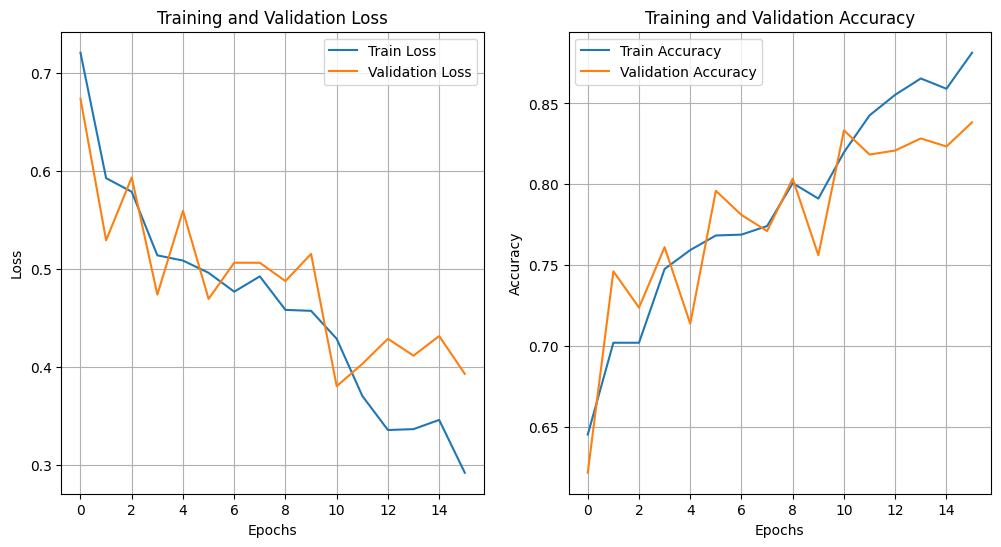

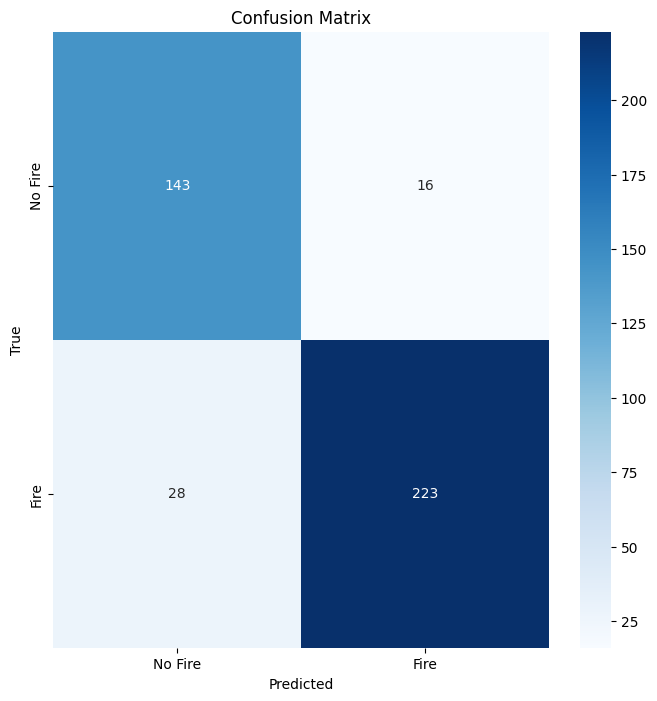

In [11]:
# Evaluation and Visualization
print("[INFO] Evaluating final model...")
metrics = evaluate_model(final_model, test_loader, ["No Fire", "Fire"], device, model_name="resnet18", save_base_path="outputs/plots/tuned/resnet18")
# Training and Validation Curves
plot_training(history, f"outputs/plots/tuned/resnet18_tuned_training_curve.png")

# Confusion Matrix
plot_confusion_matrix(
    cm=metrics["confusion_matrix"],
    classes=["No Fire", "Fire"],
    output_path=f"outputs/plots/tuned/resnet18_tuned_confusion_matrix.png"
)

# Precision-Recall Curve
if "y_probs" in metrics:
    y_true = metrics["y_true"]
    y_probs = [prob[1] for prob in metrics["y_probs"]]
    plot_precision_recall(
        y_true=y_true,
        y_scores=y_probs,
        output_path=f"outputs/plots/tuned/resnet18_tuned_precision_recall_curve.png"
    )

    # ROC Curve
    plot_roc_curve(
        y_true=y_true,
        y_scores=y_probs,
        output_path=f"outputs/plots/tuned/resnet18_tuned_roc_curve.png"
    )

print("[INFO] All results saved successfully!")